## 2. Análisis del impacto de los marcadores en la supervivencia

In [1]:
# Importaciones de los paquetes necesarios para el análisis
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from scipy.stats import ttest_ind

In [2]:
#cambiar el directorio a donde están los datos
os.chdir("/Users/Sara/Documents/TFM/TablasDatosClinicos")
with open("Datasets_dict.pkl", 'rb') as f:
     datos = pickle.load(f)

#Obtener las claves para saber como se llaman las cohortes y poder llamarlas
datos.keys()

dict_keys(['TCGA', 'AU', 'CA', 'ICGC_ARRAYS'])

In [3]:
# Diccionario de mapeo de claves antiguas a nuevas
keys = {'TCGA': 'TCGA-seq', 'AU': 'IGCG-AU-seq', 'CA' : 'IGCG-CA-seq', 'ICGC_ARRAYS':'IGCG-AU-array'}
# Crear un nuevo diccionario con las claves renombradas
datos = {keys[clave]: valor for clave, valor in datos.items()}
datos.keys()

dict_keys(['TCGA-seq', 'IGCG-AU-seq', 'IGCG-CA-seq', 'IGCG-AU-array'])

In [4]:
Marcadores = ['PSCA', 'TMPRSS4', 'CEACAM5', 'IGF2BP3', 'COL17A1', 'SDR16C5', 'SCEL', 'VILL', 'KRT6B', 'CORO2A', 'EVPL']

#### 2. 1. Análisis COX univariable y estudios de supervivencia

##### 2.1.1 Análisis COX univariable

In [55]:
def AnalisisCox(keys, Proteinas_interesantes):
    Resultados = pd.DataFrame()
    Diccionario_puntos_corte = {}
    for key in keys: 
        # Para cada cohorte, sacar el DF, resetear índices para que no coja ID como tal y nombrar como me gusta
        Cohorte = pd.DataFrame(datos.get(key))
        Cohorte = Cohorte.reset_index()
        Cohorte = Cohorte.rename(columns={Cohorte.columns[0]: "ID_Paciente", Cohorte.columns[1]: "Tiempo", Cohorte.columns[2]: "Supervivencia"})
        Cohorte_Limpio = Cohorte[["ID_Paciente", "Tiempo", "Supervivencia"]]
        columnas_coincidentes_df = pd.DataFrame()  # Define the DataFrame for coincident columns
        Listado_proteinas_levels = []
        for proteina in Proteinas_interesantes:
            if proteina in Cohorte.columns:
                columnas_coincidentes_df[proteina] = Cohorte[proteina].copy()
        Cohorte_Limpio = pd.concat([Cohorte_Limpio, columnas_coincidentes_df], axis=1)
        
        for Proteina in Cohorte_Limpio.columns[3:]:  
            Mediana = Cohorte_Limpio[Proteina].median()
            Cohorte_Limpio.loc[:, Proteina + "_levels"] = 0
            Cohorte_Limpio.loc[Cohorte_Limpio[Proteina] > Mediana, (Proteina + "_levels")] = 1
            Listado_proteinas_levels.append(Proteina + "_levels")
            print("El punto de corte de la proteína", Proteina, "en la cohorte", key, "está justo por debajo de", round(Mediana, 2))
        print("\n")
        for Proteina_level in Listado_proteinas_levels: # para cada protina, hago la tabla en funcion de la expresion
            cph = CoxPHFitter()
            cph.fit(Cohorte_Limpio, 'Tiempo', event_col='Supervivencia', formula = Proteina_level)
            print("\033[1m Análsis log cohorte " + key + " Proteina " + Proteina_level + "\033[1m")
            cph.print_summary()
            
            exp_coefs = cph.summary['exp(coef)']
            p_values = cph.summary['p']

            for exp_coef, p_value in zip(exp_coefs, p_values):
                Resultados.loc[Proteina_level, key + " HR"] = round(exp_coef, 2)
                Resultados.loc[Proteina_level, key + ' p-value'] = round(p_value, 4)
            print("\n")

    return(Resultados)

In [56]:
Resultados_COX = AnalisisCox(datos.keys(), Marcadores)

El punto de corte de la proteína PSCA en la cohorte TCGA-seq está justo por debajo de 182.68
El punto de corte de la proteína TMPRSS4 en la cohorte TCGA-seq está justo por debajo de 171.7
El punto de corte de la proteína CEACAM5 en la cohorte TCGA-seq está justo por debajo de 297.72
El punto de corte de la proteína IGF2BP3 en la cohorte TCGA-seq está justo por debajo de 3.99
El punto de corte de la proteína COL17A1 en la cohorte TCGA-seq está justo por debajo de 73.98
El punto de corte de la proteína SDR16C5 en la cohorte TCGA-seq está justo por debajo de 26.02
El punto de corte de la proteína SCEL en la cohorte TCGA-seq está justo por debajo de 11.53
El punto de corte de la proteína VILL en la cohorte TCGA-seq está justo por debajo de 70.75
El punto de corte de la proteína KRT6B en la cohorte TCGA-seq está justo por debajo de 29.98
El punto de corte de la proteína CORO2A en la cohorte TCGA-seq está justo por debajo de 21.85
El punto de corte de la proteína EVPL en la cohorte TCGA-seq 

<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -330.84
         time fit was run = 2024-06-26 18:12:41 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
PSCA_levels  0.50      1.65      0.23            0.06            0.94                1.06                2.57

             cmp to    z    p  -log2(p)
covariate                              
PSCA_levels    0.00 2.20 0.03      5.19
---
Concordance = 0.57
Partial AIC = 663.68
log-likelihood ratio test = 4.93 on 1 df
-log2(p) of ll-ratio test = 5.24



 Análsis log cohorte TCGA-seq Proteina TMPRSS4_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -331.31
         time fit was run = 2024-06-26 18:12:41 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
TMPRSS4_levels  0.45      1.57      0.23            0.01            0.90                1.01                2.45

                cmp to    z    p  -log2(p)
covariate                                 
TMPRSS4_levels    0.00 1.98 0.05      4.40
---
Concordance = 0.55
Partial AIC = 664.62
log-likelihood ratio test = 3.99 on 1 df
-log2(p) of ll-ratio test = 4.45



 Análsis log cohorte TCGA-seq Proteina CEACAM5_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -333.30
         time fit was run = 2024-06-26 18:12:41 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
CEACAM5_levels  0.02      1.02      0.23           -0.43            0.46                0.65                1.58

                cmp to    z    p  -log2(p)
covariate                                 
CEACAM5_levels    0.00 0.07 0.94      0.09
---
Concordance = 0.50
Partial AIC = 668.60
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.09



 Análsis log cohorte TCGA-seq Proteina IGF2BP3_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -332.83
         time fit was run = 2024-06-26 18:12:41 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
IGF2BP3_levels  0.22      1.24      0.22           -0.22            0.66                0.80                1.93

                cmp to    z    p  -log2(p)
covariate                                 
IGF2BP3_levels    0.00 0.97 0.33      1.59
---
Concordance = 0.55
Partial AIC = 667.67
log-likelihood ratio test = 0.94 on 1 df
-log2(p) of ll-ratio test = 1.59



 Análsis log cohorte TCGA-seq Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -330.60
         time fit was run = 2024-06-26 18:12:41 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
COL17A1_levels  0.52      1.69      0.23            0.08            0.96                1.08                2.62

                cmp to    z    p  -log2(p)
covariate                                 
COL17A1_levels    0.00 2.32 0.02      5.61
---
Concordance = 0.58
Partial AIC = 663.20
log-likelihood ratio test = 5.41 on 1 df
-log2(p) of ll-ratio test = 5.64



 Análsis log cohorte TCGA-seq Proteina SDR16C5_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -330.72
         time fit was run = 2024-06-26 18:12:42 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
SDR16C5_levels  0.51      1.67      0.23            0.07            0.96                1.07                2.60

                cmp to    z    p  -log2(p)
covariate                                 
SDR16C5_levels    0.00 2.25 0.02      5.36
---
Concordance = 0.57
Partial AIC = 663.43
log-likelihood ratio test = 5.18 on 1 df
-log2(p) of ll-ratio test = 5.45



 Análsis log cohorte TCGA-seq Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -333.00
         time fit was run = 2024-06-26 18:12:42 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
SCEL_levels  0.18      1.19      0.23           -0.27            0.62                0.76                1.87

             cmp to    z    p  -log2(p)
covariate                              
SCEL_levels    0.00 0.78 0.44      1.20
---
Concordance = 0.55
Partial AIC = 668.00
log-likelihood ratio test = 0.61 on 1 df
-log2(p) of ll-ratio test = 1.20



 Análsis log cohorte TCGA-seq Proteina VILL_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -333.18
         time fit was run = 2024-06-26 18:12:42 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
VILL_levels  0.11      1.12      0.22           -0.33            0.55                0.72                1.73

             cmp to    z    p  -log2(p)
covariate                              
VILL_levels    0.00 0.50 0.62      0.70
---
Concordance = 0.52
Partial AIC = 668.36
log-likelihood ratio test = 0.25 on 1 df
-log2(p) of ll-ratio test = 0.70



 Análsis log cohorte TCGA-seq Proteina KRT6B_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -333.09
         time fit was run = 2024-06-26 18:12:42 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
KRT6B_levels -0.15      0.86      0.23           -0.59            0.30                0.55                1.34

              cmp to     z    p  -log2(p)
covariate                                
KRT6B_levels    0.00 -0.65 0.51      0.96
---
Concordance = 0.49
Partial AIC = 668.18
log-likelihood ratio test = 0.43 on 1 df
-log2(p) of ll-ratio test = 0.97



 Análsis log cohorte TCGA-seq Proteina CORO2A_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -332.79
         time fit was run = 2024-06-26 18:12:42 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
CORO2A_levels  0.23      1.26      0.23           -0.22            0.68                0.81                1.97

               cmp to    z    p  -log2(p)
covariate                                
CORO2A_levels    0.00 1.01 0.31      1.69
---
Concordance = 0.51
Partial AIC = 667.58
log-likelihood ratio test = 1.03 on 1 df
-log2(p) of ll-ratio test = 1.69



 Análsis log cohorte TCGA-seq Proteina EVPL_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -333.30
         time fit was run = 2024-06-26 18:12:42 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
EVPL_levels  0.00      1.00      0.22           -0.44            0.44                0.65                1.55

             cmp to    z    p  -log2(p)
covariate                              
EVPL_levels    0.00 0.01 0.99      0.01
---
Concordance = 0.50
Partial AIC = 668.61
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01



El punto de corte de la proteína PSCA en la cohorte IGCG-AU-seq está justo por debajo de 72.69
El punto de corte de la proteína TMPRSS4 en la cohorte IGCG-AU-seq está justo por debajo de 276.9
El punto de corte de la proteína CEACAM5 en la cohorte IGCG-AU-seq está justo por debajo de 598.39
El punto de corte de la proteína IGF2BP3 en la cohorte IGCG-AU-seq está justo por debajo de 28.26
El punto de corte de la proteína COL17A1 en la cohorte IGCG-AU-seq está justo por debajo de 134.47
El punto de corte de la proteína SDR16C5 en la cohorte IGCG-AU-seq está justo por debajo de 43.97
El punto de corte de la proteína SCEL en la cohorte IGCG-AU-seq está justo por debajo de 36.18
El punto de corte de la proteína VILL en la cohorte IGCG-AU-seq está justo por debajo de 96.46
El punto de corte de la proteína KRT6B en la cohorte IGCG-AU-seq está justo por debajo de 12.01
El punto de corte de la proteína CORO2A en la cohorte IGCG-AU-seq está justo por debajo de 33.9
El punto de corte de la prote

<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -119.31
         time fit was run = 2024-06-26 18:12:42 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
PSCA_levels  0.60      1.81      0.34           -0.08            1.27                0.93                3.55

             cmp to    z    p  -log2(p)
covariate                              
PSCA_levels    0.00 1.74 0.08      3.61
---
Concordance = 0.59
Partial AIC = 240.62
log-likelihood ratio test = 3.12 on 1 df
-log2(p) of ll-ratio test = 3.69



 Análsis log cohorte IGCG-AU-seq Proteina TMPRSS4_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -119.61
         time fit was run = 2024-06-26 18:12:42 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
TMPRSS4_levels  0.55      1.72      0.35           -0.13            1.22                0.88                3.40

                cmp to    z    p  -log2(p)
covariate                                 
TMPRSS4_levels    0.00 1.58 0.12      3.12
---
Concordance = 0.55
Partial AIC = 241.22
log-likelihood ratio test = 2.52 on 1 df
-log2(p) of ll-ratio test = 3.15



 Análsis log cohorte IGCG-AU-seq Proteina CEACAM5_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -120.45
         time fit was run = 2024-06-26 18:12:42 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
CEACAM5_levels -0.31      0.74      0.34           -0.97            0.35                0.38                1.42

                cmp to     z    p  -log2(p)
covariate                                  
CEACAM5_levels    0.00 -0.91 0.36      1.47
---
Concordance = 0.54
Partial AIC = 242.90
log-likelihood ratio test = 0.84 on 1 df
-log2(p) of ll-ratio test = 1.48



 Análsis log cohorte IGCG-AU-seq Proteina IGF2BP3_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -119.19
         time fit was run = 2024-06-26 18:12:42 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
IGF2BP3_levels  0.62      1.87      0.34           -0.05            1.30                0.95                3.67

                cmp to    z    p  -log2(p)
covariate                                 
IGF2BP3_levels    0.00 1.81 0.07      3.84
---
Concordance = 0.57
Partial AIC = 240.39
log-likelihood ratio test = 3.35 on 1 df
-log2(p) of ll-ratio test = 3.90



 Análsis log cohorte IGCG-AU-seq Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -118.90
         time fit was run = 2024-06-26 18:12:43 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
COL17A1_levels  0.67      1.96      0.34           -0.00            1.35                1.00                3.85

                cmp to    z    p  -log2(p)
covariate                                 
COL17A1_levels    0.00 1.96 0.05      4.31
---
Concordance = 0.59
Partial AIC = 239.79
log-likelihood ratio test = 3.95 on 1 df
-log2(p) of ll-ratio test = 4.41



 Análsis log cohorte IGCG-AU-seq Proteina SDR16C5_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -120.68
         time fit was run = 2024-06-26 18:12:43 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
SDR16C5_levels -0.21      0.81      0.34           -0.87            0.45                0.42                1.57

                cmp to     z    p  -log2(p)
covariate                                  
SDR16C5_levels    0.00 -0.62 0.54      0.90
---
Concordance = 0.54
Partial AIC = 243.36
log-likelihood ratio test = 0.38 on 1 df
-log2(p) of ll-ratio test = 0.90



 Análsis log cohorte IGCG-AU-seq Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -118.14
         time fit was run = 2024-06-26 18:12:43 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
SCEL_levels  0.82      2.27      0.36            0.12            1.52                1.13                4.56

             cmp to    z    p  -log2(p)
covariate                              
SCEL_levels    0.00 2.29 0.02      5.52
---
Concordance = 0.59
Partial AIC = 238.28
log-likelihood ratio test = 5.46 on 1 df
-log2(p) of ll-ratio test = 5.68



 Análsis log cohorte IGCG-AU-seq Proteina VILL_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -120.48
         time fit was run = 2024-06-26 18:12:43 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
VILL_levels -0.31      0.74      0.35           -0.99            0.38                0.37                1.46

             cmp to     z    p  -log2(p)
covariate                               
VILL_levels    0.00 -0.87 0.38      1.39
---
Concordance = 0.51
Partial AIC = 242.96
log-likelihood ratio test = 0.78 on 1 df
-log2(p) of ll-ratio test = 1.40



 Análsis log cohorte IGCG-AU-seq Proteina KRT6B_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -118.95
         time fit was run = 2024-06-26 18:12:43 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
KRT6B_levels  0.67      1.95      0.35           -0.02            1.35                0.99                3.87

              cmp to    z    p  -log2(p)
covariate                               
KRT6B_levels    0.00 1.92 0.06      4.18
---
Concordance = 0.56
Partial AIC = 239.90
log-likelihood ratio test = 3.84 on 1 df
-log2(p) of ll-ratio test = 4.32



 Análsis log cohorte IGCG-AU-seq Proteina CORO2A_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -120.25
         time fit was run = 2024-06-26 18:12:43 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
CORO2A_levels -0.39      0.68      0.35           -1.07            0.30                0.34                1.35

               cmp to     z    p  -log2(p)
covariate                                 
CORO2A_levels    0.00 -1.11 0.27      1.90
---
Concordance = 0.55
Partial AIC = 242.49
log-likelihood ratio test = 1.25 on 1 df
-log2(p) of ll-ratio test = 1.92



 Análsis log cohorte IGCG-AU-seq Proteina EVPL_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -119.96
         time fit was run = 2024-06-26 18:12:43 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
EVPL_levels  0.47      1.60      0.35           -0.22            1.16                0.80                3.18

             cmp to    z    p  -log2(p)
covariate                              
EVPL_levels    0.00 1.34 0.18      2.46
---
Concordance = 0.55
Partial AIC = 241.92
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.50



El punto de corte de la proteína PSCA en la cohorte IGCG-CA-seq está justo por debajo de 99.82
El punto de corte de la proteína TMPRSS4 en la cohorte IGCG-CA-seq está justo por debajo de 351.14
El punto de corte de la proteína CEACAM5 en la cohorte IGCG-CA-seq está justo por debajo de 878.91
El punto de corte de la proteína IGF2BP3 en la cohorte IGCG-CA-seq está justo por debajo de 24.23
El punto de corte de la proteína COL17A1 en la cohorte IGCG-CA-seq está justo por debajo de 397.31
El punto de corte de la proteína SDR16C5 en la cohorte IGCG-CA-seq está justo por debajo de 47.74
El punto de corte de la proteína SCEL en la cohorte IGCG-CA-seq está justo por debajo de 64.26
El punto de corte de la proteína VILL en la cohorte IGCG-CA-seq está justo por debajo de 182.57
El punto de corte de la proteína KRT6B en la cohorte IGCG-CA-seq está justo por debajo de 22.55
El punto de corte de la proteína CORO2A en la cohorte IGCG-CA-seq está justo por debajo de 33.86
El punto de corte de la pr

<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -561.52
         time fit was run = 2024-06-26 18:12:43 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
PSCA_levels  0.42      1.52      0.18            0.07            0.77                1.07                2.15

             cmp to    z    p  -log2(p)
covariate                              
PSCA_levels    0.00 2.36 0.02      5.78
---
Concordance = 0.55
Partial AIC = 1125.04
log-likelihood ratio test = 5.61 on 1 df
-log2(p) of ll-ratio test = 5.81



 Análsis log cohorte IGCG-CA-seq Proteina TMPRSS4_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -559.42
         time fit was run = 2024-06-26 18:12:43 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
TMPRSS4_levels  0.56      1.75      0.18            0.21            0.91                1.23                2.48

                cmp to    z      p  -log2(p)
covariate                                   
TMPRSS4_levels    0.00 3.13 <0.005      9.16
---
Concordance = 0.56
Partial AIC = 1120.83
log-likelihood ratio test = 9.82 on 1 df
-log2(p) of ll-ratio test = 9.18



 Análsis log cohorte IGCG-CA-seq Proteina CEACAM5_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -564.32
         time fit was run = 2024-06-26 18:12:44 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
CEACAM5_levels  0.01      1.01      0.18           -0.33            0.36                0.72                1.43

                cmp to    z    p  -log2(p)
covariate                                 
CEACAM5_levels    0.00 0.06 0.95      0.08
---
Concordance = 0.48
Partial AIC = 1130.65
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.08



 Análsis log cohorte IGCG-CA-seq Proteina IGF2BP3_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -563.84
         time fit was run = 2024-06-26 18:12:44 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
IGF2BP3_levels  0.17      1.19      0.18           -0.17            0.52                0.84                1.68

                cmp to    z    p  -log2(p)
covariate                                 
IGF2BP3_levels    0.00 0.98 0.33      1.61
---
Concordance = 0.52
Partial AIC = 1129.69
log-likelihood ratio test = 0.96 on 1 df
-log2(p) of ll-ratio test = 1.62



 Análsis log cohorte IGCG-CA-seq Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -562.19
         time fit was run = 2024-06-26 18:12:44 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
COL17A1_levels  0.37      1.44      0.18            0.02            0.71                1.02                2.04

                cmp to    z    p  -log2(p)
covariate                                 
COL17A1_levels    0.00 2.07 0.04      4.69
---
Concordance = 0.55
Partial AIC = 1126.37
log-likelihood ratio test = 4.28 on 1 df
-log2(p) of ll-ratio test = 4.70



 Análsis log cohorte IGCG-CA-seq Proteina SDR16C5_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -564.22
         time fit was run = 2024-06-26 18:12:44 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
SDR16C5_levels  0.08      1.08      0.18           -0.26            0.42                0.77                1.53

                cmp to    z    p  -log2(p)
covariate                                 
SDR16C5_levels    0.00 0.46 0.65      0.62
---
Concordance = 0.50
Partial AIC = 1130.44
log-likelihood ratio test = 0.21 on 1 df
-log2(p) of ll-ratio test = 0.62



 Análsis log cohorte IGCG-CA-seq Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -557.36
         time fit was run = 2024-06-26 18:12:44 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
SCEL_levels  0.67      1.96      0.18            0.32            1.03                1.37                2.80

             cmp to    z      p  -log2(p)
covariate                                
SCEL_levels    0.00 3.72 <0.005     12.29
---
Concordance = 0.58
Partial AIC = 1116.72
log-likelihood ratio test = 13.93 on 1 df
-log2(p) of ll-ratio test = 12.37



 Análsis log cohorte IGCG-CA-seq Proteina VILL_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -564.32
         time fit was run = 2024-06-26 18:12:44 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
VILL_levels -0.02      0.98      0.18           -0.37            0.32                0.69                1.38

             cmp to     z    p  -log2(p)
covariate                               
VILL_levels    0.00 -0.13 0.90      0.16
---
Concordance = 0.52
Partial AIC = 1130.63
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.16



 Análsis log cohorte IGCG-CA-seq Proteina KRT6B_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -564.17
         time fit was run = 2024-06-26 18:12:44 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
KRT6B_levels  0.10      1.10      0.18           -0.25            0.44                0.78                1.56

              cmp to    z    p  -log2(p)
covariate                               
KRT6B_levels    0.00 0.56 0.58      0.80
---
Concordance = 0.52
Partial AIC = 1130.34
log-likelihood ratio test = 0.31 on 1 df
-log2(p) of ll-ratio test = 0.80



 Análsis log cohorte IGCG-CA-seq Proteina CORO2A_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -564.27
         time fit was run = 2024-06-26 18:12:44 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
CORO2A_levels -0.06      0.94      0.18           -0.41            0.28                0.67                1.33

               cmp to     z    p  -log2(p)
covariate                                 
CORO2A_levels    0.00 -0.35 0.73      0.46
---
Concordance = 0.52
Partial AIC = 1130.53
log-likelihood ratio test = 0.12 on 1 df
-log2(p) of ll-ratio test = 0.46



 Análsis log cohorte IGCG-CA-seq Proteina EVPL_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -563.85
         time fit was run = 2024-06-26 18:12:45 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
EVPL_levels  0.17      1.19      0.18           -0.17            0.52                0.84                1.68

             cmp to    z    p  -log2(p)
covariate                              
EVPL_levels    0.00 0.97 0.33      1.60
---
Concordance = 0.52
Partial AIC = 1129.70
log-likelihood ratio test = 0.95 on 1 df
-log2(p) of ll-ratio test = 1.60



El punto de corte de la proteína PSCA en la cohorte IGCG-AU-array está justo por debajo de 6.45
El punto de corte de la proteína TMPRSS4 en la cohorte IGCG-AU-array está justo por debajo de 6.93
El punto de corte de la proteína CEACAM5 en la cohorte IGCG-AU-array está justo por debajo de 9.14
El punto de corte de la proteína IGF2BP3 en la cohorte IGCG-AU-array está justo por debajo de 6.5
El punto de corte de la proteína COL17A1 en la cohorte IGCG-AU-array está justo por debajo de 9.36
El punto de corte de la proteína SDR16C5 en la cohorte IGCG-AU-array está justo por debajo de 6.92
El punto de corte de la proteína SCEL en la cohorte IGCG-AU-array está justo por debajo de 3.26
El punto de corte de la proteína VILL en la cohorte IGCG-AU-array está justo por debajo de 7.0
El punto de corte de la proteína KRT6B en la cohorte IGCG-AU-array está justo por debajo de 7.43
El punto de corte de la proteína CORO2A en la cohorte IGCG-AU-array está justo por debajo de 5.95
El punto de corte de l

<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -782.30
         time fit was run = 2024-06-26 18:12:45 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
PSCA_levels  0.34      1.41      0.16            0.03            0.66                1.03                1.93

             cmp to    z    p  -log2(p)
covariate                              
PSCA_levels    0.00 2.15 0.03      4.98
---
Concordance = 0.54
Partial AIC = 1566.61
log-likelihood ratio test = 4.64 on 1 df
-log2(p) of ll-ratio test = 5.00



 Análsis log cohorte IGCG-AU-array Proteina TMPRSS4_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -784.37
         time fit was run = 2024-06-26 18:12:45 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
TMPRSS4_levels -0.11      0.89      0.16           -0.42            0.20                0.66                1.22

                cmp to     z    p  -log2(p)
covariate                                  
TMPRSS4_levels    0.00 -0.71 0.48      1.06
---
Concordance = 0.50
Partial AIC = 1570.74
log-likelihood ratio test = 0.50 on 1 df
-log2(p) of ll-ratio test = 1.06



 Análsis log cohorte IGCG-AU-array Proteina CEACAM5_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -784.62
         time fit was run = 2024-06-26 18:12:45 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
CEACAM5_levels  0.01      1.01      0.16           -0.30            0.32                0.74                1.37

                cmp to    z    p  -log2(p)
covariate                                 
CEACAM5_levels    0.00 0.04 0.96      0.05
---
Concordance = 0.49
Partial AIC = 1571.24
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05



 Análsis log cohorte IGCG-AU-array Proteina IGF2BP3_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -783.30
         time fit was run = 2024-06-26 18:12:45 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
IGF2BP3_levels  0.26      1.30      0.16           -0.05            0.57                0.95                1.77

                cmp to    z    p  -log2(p)
covariate                                 
IGF2BP3_levels    0.00 1.62 0.10      3.26
---
Concordance = 0.54
Partial AIC = 1568.59
log-likelihood ratio test = 2.65 on 1 df
-log2(p) of ll-ratio test = 3.27



 Análsis log cohorte IGCG-AU-array Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -778.95
         time fit was run = 2024-06-26 18:12:45 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
COL17A1_levels  0.54      1.71      0.16            0.22            0.85                1.25                2.34

                cmp to    z      p  -log2(p)
covariate                                   
COL17A1_levels    0.00 3.34 <0.005     10.24
---
Concordance = 0.57
Partial AIC = 1559.89
log-likelihood ratio test = 11.35 on 1 df
-log2(p) of ll-ratio test = 10.37



 Análsis log cohorte IGCG-AU-array Proteina SDR16C5_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -784.14
         time fit was run = 2024-06-26 18:12:45 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
SDR16C5_levels -0.16      0.86      0.16           -0.47            0.16                0.63                1.17

                cmp to     z    p  -log2(p)
covariate                                  
SDR16C5_levels    0.00 -0.98 0.33      1.61
---
Concordance = 0.51
Partial AIC = 1570.28
log-likelihood ratio test = 0.96 on 1 df
-log2(p) of ll-ratio test = 1.61



 Análsis log cohorte IGCG-AU-array Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -779.35
         time fit was run = 2024-06-26 18:12:46 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
SCEL_levels  0.52      1.68      0.16            0.20            0.83                1.22                2.30

             cmp to    z      p  -log2(p)
covariate                                
SCEL_levels    0.00 3.22 <0.005      9.62
---
Concordance = 0.57
Partial AIC = 1560.70
log-likelihood ratio test = 10.54 on 1 df
-log2(p) of ll-ratio test = 9.74



 Análsis log cohorte IGCG-AU-array Proteina VILL_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -784.31
         time fit was run = 2024-06-26 18:12:46 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
VILL_levels -0.13      0.88      0.16           -0.44            0.19                0.65                1.20

             cmp to     z    p  -log2(p)
covariate                               
VILL_levels    0.00 -0.79 0.43      1.22
---
Concordance = 0.52
Partial AIC = 1570.62
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.22



 Análsis log cohorte IGCG-AU-array Proteina KRT6B_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -779.98
         time fit was run = 2024-06-26 18:12:46 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
KRT6B_levels  0.48      1.62      0.16            0.17            0.80                1.19                2.22

              cmp to    z      p  -log2(p)
covariate                                 
KRT6B_levels    0.00 3.03 <0.005      8.66
---
Concordance = 0.58
Partial AIC = 1561.96
log-likelihood ratio test = 9.28 on 1 df
-log2(p) of ll-ratio test = 8.75



 Análsis log cohorte IGCG-AU-array Proteina CORO2A_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -784.17
         time fit was run = 2024-06-26 18:12:46 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
CORO2A_levels  0.15      1.16      0.16           -0.16            0.46                0.85                1.59

               cmp to    z    p  -log2(p)
covariate                                
CORO2A_levels    0.00 0.95 0.34      1.54
---
Concordance = 0.53
Partial AIC = 1570.35
log-likelihood ratio test = 0.90 on 1 df
-log2(p) of ll-ratio test = 1.54



 Análsis log cohorte IGCG-AU-array Proteina EVPL_levels


<lifelines.CoxPHFitter: fitted with 267 total observations, 106 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 161
   partial log-likelihood = -784.43
         time fit was run = 2024-06-26 18:12:46 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
EVPL_levels -0.10      0.91      0.16           -0.41            0.21                0.66                1.24

             cmp to     z    p  -log2(p)
covariate                               
EVPL_levels    0.00 -0.62 0.54      0.89
---
Concordance = 0.52
Partial AIC = 1570.86
log-likelihood ratio test = 0.38 on 1 df
-log2(p) of ll-ratio test = 0.89

In [57]:
Resultados_COX

,TCGA-seq HR,TCGA-seq p-value,IGCG-AU-seq HR,IGCG-AU-seq p-value,IGCG-CA-seq HR,IGCG-CA-seq p-value,IGCG-AU-array HR,IGCG-AU-array p-value
PSCA_levels,1.65,0.0275,1.81,0.0821,1.52,0.0182,1.41,0.0317
TMPRSS4_levels,1.57,0.0473,1.72,0.1152,1.75,0.0017,0.89,0.4789
CEACAM5_levels,1.02,0.9422,0.74,0.3611,1.01,0.9485,1.01,0.9643
IGF2BP3_levels,1.24,0.3323,1.87,0.0698,1.19,0.3270,1.30,0.1047
COL17A1_levels,1.69,0.0205,1.96,0.0504,1.44,0.0388,1.71,0.0008
SDR16C5_levels,1.67,0.0243,0.81,0.5368,1.08,0.6485,0.86,0.3281
SCEL_levels,1.19,0.4357,2.27,0.0218,1.96,0.0002,1.68,0.0013
VILL_levels,1.12,0.6171,0.74,0.3818,0.98,0.8976,0.88,0.4288
KRT6B_levels,0.86,0.5127,1.95,0.0553,1.10,0.5754,1.62,0.0025
CORO2A_levels,1.26,0.3108,0.68,0.2683,0.94,0.7288,1.16,0.3438


In [58]:
def Significancia(datos):
    HR = datos[["TCGA-seq HR", "IGCG-AU-seq HR", "IGCG-CA-seq HR", "IGCG-AU-array HR"]] > 1.4
    p_value = datos[["TCGA-seq p-value", "IGCG-AU-seq p-value", "IGCG-CA-seq p-value", "IGCG-AU-array p-value"]] < 0.05
    contador_hr = HR.sum(axis=1)
    contador_pvalue = p_value.sum(axis=1)
    # Filtrar filas que cumplan con ambas condiciones al menos 3 veces
    filas_cumplen = datos[(contador_hr >= 3) & (contador_pvalue >= 3)]

    return(filas_cumplen)

In [59]:
COX = Significancia(Resultados_COX)
COX

,TCGA-seq HR,TCGA-seq p-value,IGCG-AU-seq HR,IGCG-AU-seq p-value,IGCG-CA-seq HR,IGCG-CA-seq p-value,IGCG-AU-array HR,IGCG-AU-array p-value
PSCA_levels,1.65,0.0275,1.81,0.0821,1.52,0.0182,1.41,0.0317
COL17A1_levels,1.69,0.0205,1.96,0.0504,1.44,0.0388,1.71,0.0008
SCEL_levels,1.19,0.4357,2.27,0.0218,1.96,0.0002,1.68,0.0013


##### 2.1.2. Análisis log Rank

In [60]:
def GraficaSupervivenciaLogRank (keys, Proteinas_interesantes):
    Resultados = pd.DataFrame()
    for key in keys:
        # Para cada cohorte, sacar el DF, resetear índices para que no coja ID como tal y nombrar como me gusta
        Cohorte = pd.DataFrame(datos.get(key))
        Cohorte = Cohorte.reset_index()
        Cohorte = Cohorte.rename(columns={Cohorte.columns[0]: "ID_Paciente", Cohorte.columns[1]: "Tiempo", Cohorte.columns[2]: "Supervivencia"})
        Cohorte_Limpio = Cohorte[["ID_Paciente", "Tiempo", "Supervivencia"]]
        columnas_coincidentes_df = pd.DataFrame()  # Define the DataFrame for coincident columns
        Listado_proteinas_levels = []
        for proteina in Proteinas_interesantes:
            if proteina in Cohorte.columns:
                columnas_coincidentes_df[proteina] = Cohorte[proteina].copy()
        Cohorte_Limpio = pd.concat([Cohorte_Limpio, columnas_coincidentes_df], axis=1)
        for Proteina in Cohorte_Limpio.columns[3:]:  
            Mediana = Cohorte_Limpio[Proteina].median()
            Cohorte_Limpio.loc[:, Proteina + "_levels"] = 0
            Cohorte_Limpio.loc[Cohorte_Limpio[Proteina] > Mediana, (Proteina + "_levels")] = 1
            Listado_proteinas_levels.append(Proteina + "_levels")
        for Proteina_level in Listado_proteinas_levels:            
            lrt = logrank_test(
                durations_A = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 1]['Tiempo'],
                durations_B = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 0]['Tiempo'],
                event_observed_A = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 1]['Supervivencia'],
                event_observed_B = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 0]['Supervivencia'])
            print("\033[1m Análsis log cohorte " + key + " Proteina " + Proteina_level + "\033[1m")
            lrt.print_summary()
            print("\n")

            Resultados.loc[Proteina_level, key + ' p-value'] = lrt.p_value
    
    return(Resultados)

In [61]:
Resultados_logRank = GraficaSupervivenciaLogRank(datos.keys(), Marcadores)
Resultados_logRank

 Análsis log cohorte TCGA-seq Proteina PSCA_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.96 0.03      5.27



 Análsis log cohorte TCGA-seq Proteina TMPRSS4_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.00 0.05      4.45



 Análsis log cohorte TCGA-seq Proteina CEACAM5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.94      0.08



 Análsis log cohorte TCGA-seq Proteina IGF2BP3_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.94 0.33      1.59



 Análsis log cohorte TCGA-seq Proteina COL17A1_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.49 0.02      5.71



 Análsis log cohorte TCGA-seq Proteina SDR16C5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.18 0.02      5.45



 Análsis log cohorte TCGA-seq Proteina SCEL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.61 0.43      1.20



 Análsis log cohorte TCGA-seq Proteina VILL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.25 0.62      0.70



 Análsis log cohorte TCGA-seq Proteina KRT6B_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.43 0.51      0.97



 Análsis log cohorte TCGA-seq Proteina CORO2A_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.03 0.31      1.69



 Análsis log cohorte TCGA-seq Proteina EVPL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.99      0.01



 Análsis log cohorte IGCG-AU-seq Proteina PSCA_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.11 0.08      3.69



 Análsis log cohorte IGCG-AU-seq Proteina TMPRSS4_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.54 0.11      3.17



 Análsis log cohorte IGCG-AU-seq Proteina CEACAM5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.84 0.36      1.48



 Análsis log cohorte IGCG-AU-seq Proteina IGF2BP3_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.38 0.07      3.93



 Análsis log cohorte IGCG-AU-seq Proteina COL17A1_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.97 0.05      4.43



 Análsis log cohorte IGCG-AU-seq Proteina SDR16C5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.38 0.54      0.90



 Análsis log cohorte IGCG-AU-seq Proteina SCEL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.54 0.02      5.75



 Análsis log cohorte IGCG-AU-seq Proteina VILL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.77 0.38      1.40



 Análsis log cohorte IGCG-AU-seq Proteina KRT6B_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.81 0.05      4.29



 Análsis log cohorte IGCG-AU-seq Proteina CORO2A_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.24 0.27      1.91



 Análsis log cohorte IGCG-AU-seq Proteina EVPL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.82 0.18      2.49



 Análsis log cohorte IGCG-CA-seq Proteina PSCA_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.66 0.02      5.85



 Análsis log cohorte IGCG-CA-seq Proteina TMPRSS4_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.04 <0.005      9.35



 Análsis log cohorte IGCG-CA-seq Proteina CEACAM5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.95      0.07



 Análsis log cohorte IGCG-CA-seq Proteina IGF2BP3_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.96 0.33      1.62



 Análsis log cohorte IGCG-CA-seq Proteina COL17A1_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.32 0.04      4.73



 Análsis log cohorte IGCG-CA-seq Proteina SDR16C5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.21 0.65      0.62



 Análsis log cohorte IGCG-CA-seq Proteina SCEL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          14.34 <0.005     12.68



 Análsis log cohorte IGCG-CA-seq Proteina VILL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.90      0.16



 Análsis log cohorte IGCG-CA-seq Proteina KRT6B_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.31 0.58      0.79



 Análsis log cohorte IGCG-CA-seq Proteina CORO2A_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.12 0.73      0.46



 Análsis log cohorte IGCG-CA-seq Proteina EVPL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.95 0.33      1.61



 Análsis log cohorte IGCG-AU-array Proteina PSCA_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.66 0.03      5.02



 Análsis log cohorte IGCG-AU-array Proteina TMPRSS4_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.50 0.48      1.07



 Análsis log cohorte IGCG-AU-array Proteina CEACAM5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.96      0.05



 Análsis log cohorte IGCG-AU-array Proteina IGF2BP3_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.65 0.10      3.27



 Análsis log cohorte IGCG-AU-array Proteina COL17A1_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.46 <0.005     10.46



 Análsis log cohorte IGCG-AU-array Proteina SDR16C5_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.96 0.33      1.61



 Análsis log cohorte IGCG-AU-array Proteina SCEL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.61 <0.005      9.80



 Análsis log cohorte IGCG-AU-array Proteina VILL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.63 0.43      1.23



 Análsis log cohorte IGCG-AU-array Proteina KRT6B_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.35 <0.005      8.81



 Análsis log cohorte IGCG-AU-array Proteina CORO2A_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.90 0.34      1.54



 Análsis log cohorte IGCG-AU-array Proteina EVPL_levels


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.38 0.54      0.90

,TCGA-seq p-value,IGCG-AU-seq p-value,IGCG-CA-seq p-value,IGCG-AU-array p-value
PSCA_levels,0.025969,0.077674,0.017391,0.030819
TMPRSS4_levels,0.045599,0.111054,0.001531,0.477944
CEACAM5_levels,0.943168,0.359287,0.950591,0.963681
IGF2BP3_levels,0.332047,0.065826,0.326273,0.103493
COL17A1_levels,0.019076,0.046378,0.037749,0.000709
SDR16C5_levels,0.022846,0.536100,0.648553,0.327723
SCEL_levels,0.434939,0.018593,0.000153,0.001123
VILL_levels,0.616909,0.380019,0.897227,0.427532
KRT6B_levels,0.511941,0.051004,0.577995,0.002233
CORO2A_levels,0.310662,0.265324,0.728132,0.343806


In [62]:
def Significancialog(datos):
    p_value = datos[["TCGA-seq p-value", "IGCG-AU-seq p-value", "IGCG-CA-seq p-value", "IGCG-AU-array p-value"]] < 0.05
    contador_pvalue = p_value.sum(axis=1)
    # Filtrar filas que cumplan con ambas condiciones al menos 3 veces
    filas_cumplen = datos[contador_pvalue >= 3]
    return(filas_cumplen)

In [63]:
logRank = Significancialog(Resultados_logRank)
logRank

,TCGA-seq p-value,IGCG-AU-seq p-value,IGCG-CA-seq p-value,IGCG-AU-array p-value
PSCA_levels,0.025969,0.077674,0.017391,0.030819
COL17A1_levels,0.019076,0.046378,0.037749,0.000709
SCEL_levels,0.434939,0.018593,0.000153,0.001123


##### 2.1.3. Realización de las curvas de supervivencia

In [64]:
def GraficaSupervivencia (keys, Proteinas_interesantes, logRank, CoxUni):
    for key in keys:
        # Para cada cohorte, sacar el DF, resetear índices para que no coja ID como tal y nombrar como me gusta
        Cohorte = pd.DataFrame(datos.get(key))
        Cohorte = Cohorte.reset_index()
        Cohorte = Cohorte.rename(columns={Cohorte.columns[0]: "ID_Paciente", Cohorte.columns[1]: "Tiempo", Cohorte.columns[2]: "Supervivencia"})
        Cohorte_Limpio = Cohorte[["ID_Paciente", "Tiempo", "Supervivencia"]]
        columnas_coincidentes_df = pd.DataFrame()  # Define the DataFrame for coincident columns
        Listado_proteinas_levels = []
        for proteina in Proteinas_interesantes:
            if proteina in Cohorte.columns:
                columnas_coincidentes_df[proteina] = Cohorte[proteina].copy()
        Cohorte_Limpio = pd.concat([Cohorte_Limpio, columnas_coincidentes_df], axis=1)
        for Proteina in Cohorte_Limpio.columns[3:]:  
            Mediana = Cohorte_Limpio[Proteina].median()
            Cohorte_Limpio.loc[:, Proteina + "_levels"] = 0
            Cohorte_Limpio.loc[Cohorte_Limpio[Proteina] > Mediana, (Proteina + "_levels")] = 1
            Listado_proteinas_levels.append(Proteina + "_levels")
        for Proteina_level in Listado_proteinas_levels: # para cada protina, hago la tabla en funcion de la expresion
            kmf_low = KaplanMeierFitter()
            kmf_low.fit(durations = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 0]['Tiempo'], event_observed = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 0]["Supervivencia"])

            kmf_high = KaplanMeierFitter()
            kmf_high.fit(durations = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 1]['Tiempo'], event_observed = Cohorte_Limpio[Cohorte_Limpio[Proteina_level] == 1]["Supervivencia"])

            plt.figure(figsize=(10, 6))
            kmf_low.plot_survival_function(label='Baja Expression' + "          " + "n =" + str((Cohorte_Limpio[Proteina_level] == 0).sum()))
            kmf_high.plot_survival_function(label='Alta Expression' + "          "  + "n =" + str((Cohorte_Limpio[Proteina_level] == 1).sum()))
            plt.legend(fontsize='large')
            plt.text(0.05, 0.05, 'Log Rank test p-valor = '+ str(logRank.at[Proteina_level, str(key) + ' p-value'].round(4)), fontsize=12, transform=plt.gca().transAxes)
            plt.text(0.65, 0.75, 'Cociente de riesgos = '+ str(CoxUni.at[Proteina_level, str(key) + ' HR'].round(2)), fontsize=12, transform=plt.gca().transAxes)
            plt.text(0.65, 0.70, 'p-valor = '+ str(CoxUni.at[Proteina_level, str(key) + ' p-value'].round(4)), fontsize=12, transform=plt.gca().transAxes)
            plt.xlabel("Tiempo (días)")
            plt.ylabel("Probabilidad de supervivencia")
            plt.title("Curva de supervivencia" + Proteina_level)
            plt.title("Función de supervivencia Kaplan-Meier para " +  Proteina_level.split('_')[0] + " en la cohorte " + key)
            #plt.savefig("/Users/Sara/Documents/TFM/Figuras/Grafico" + Proteina_level + key + ".png")


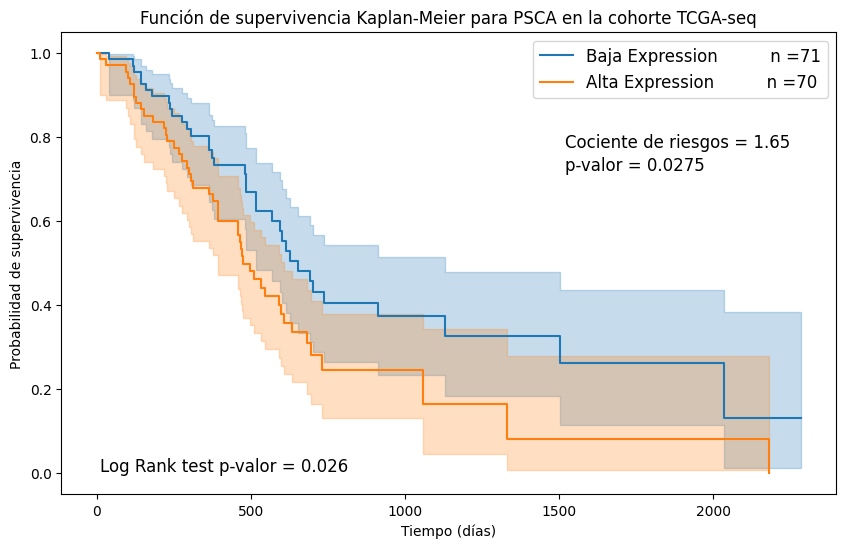

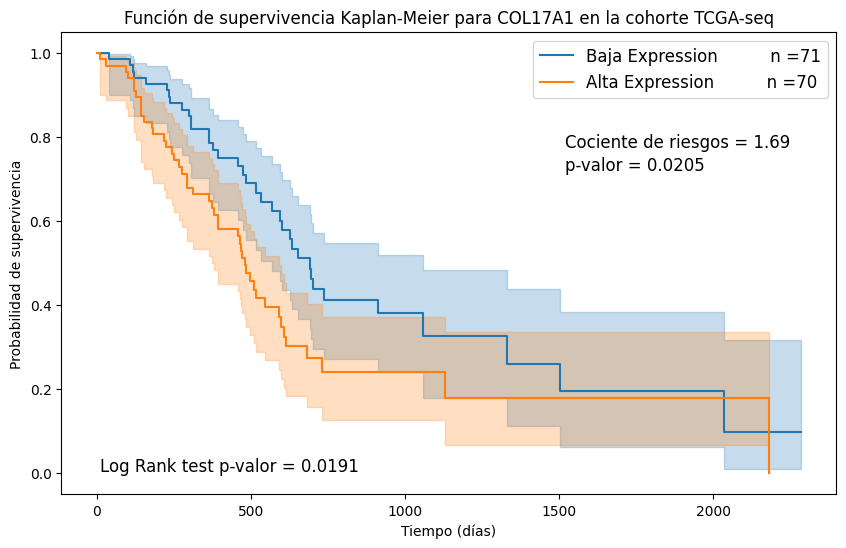

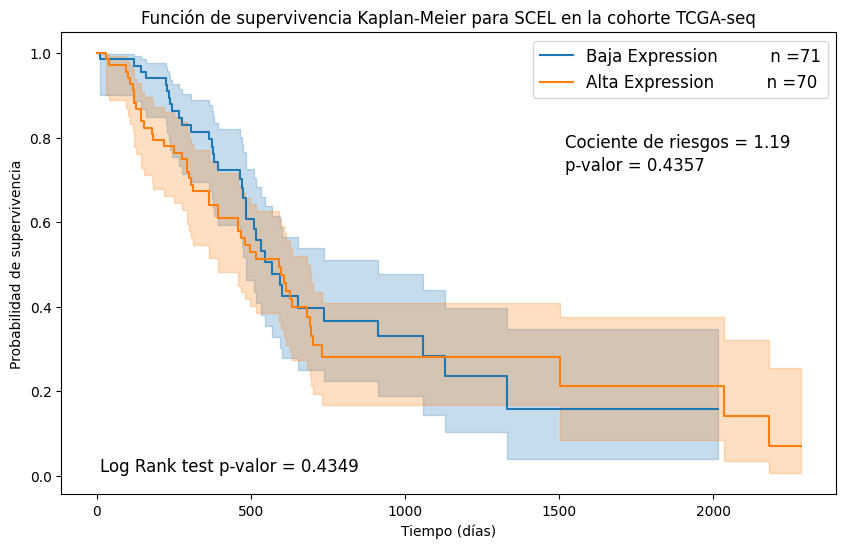

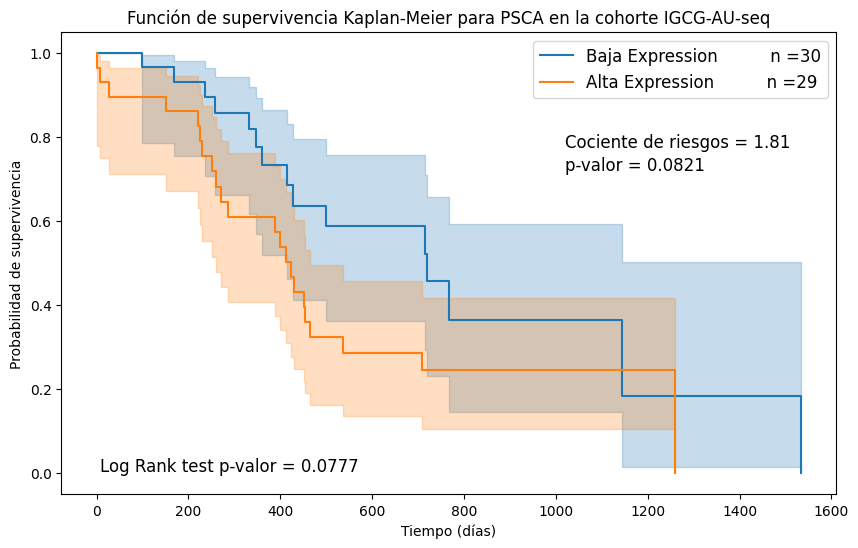

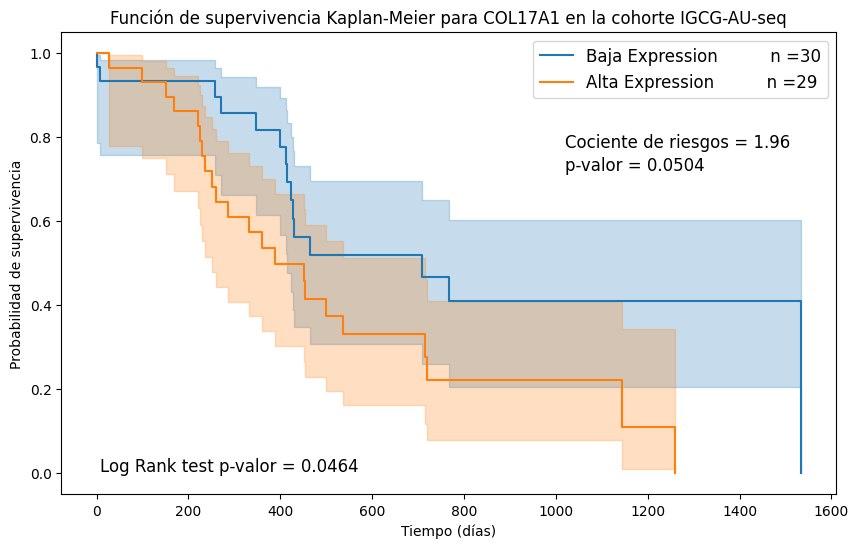

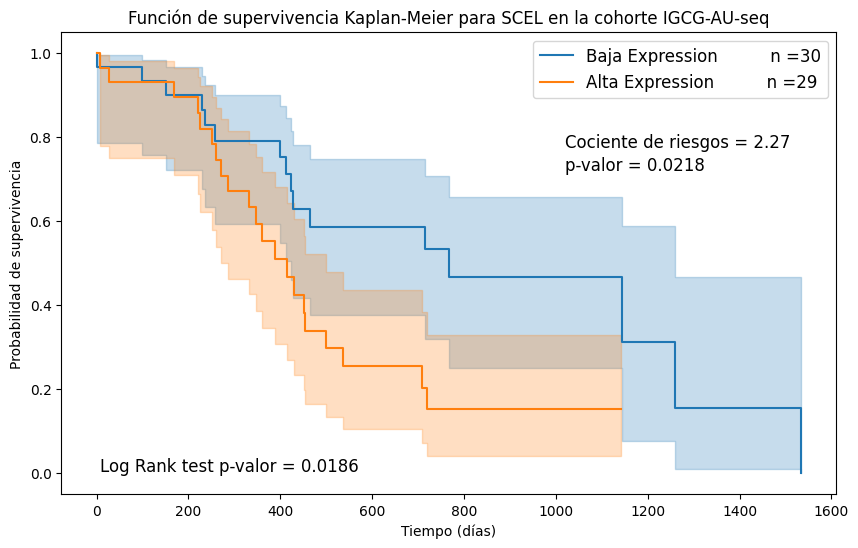

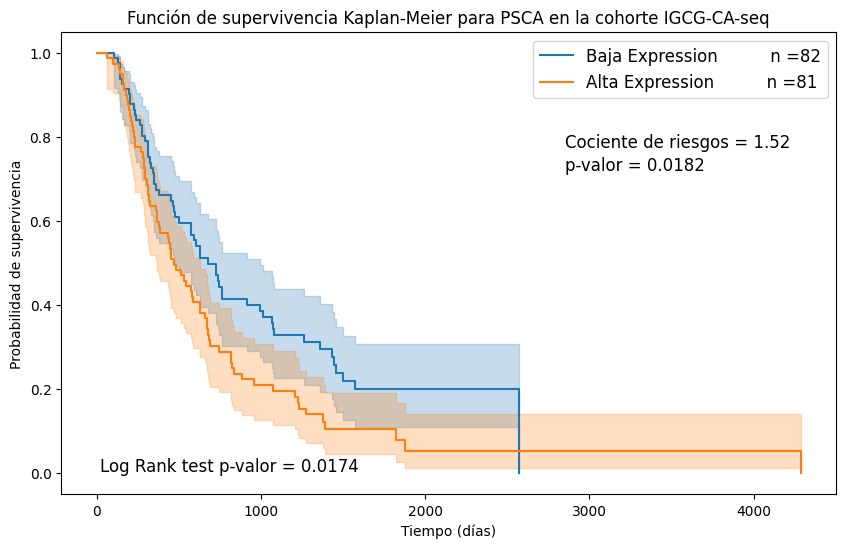

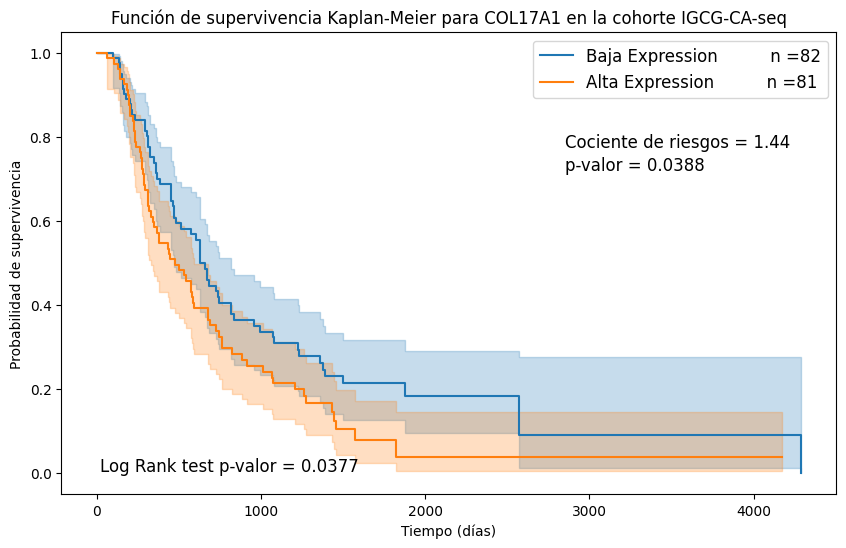

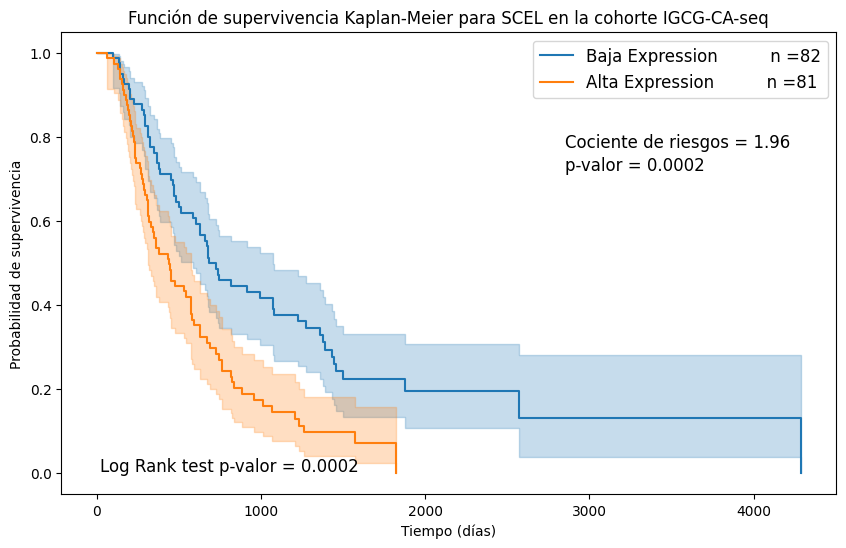

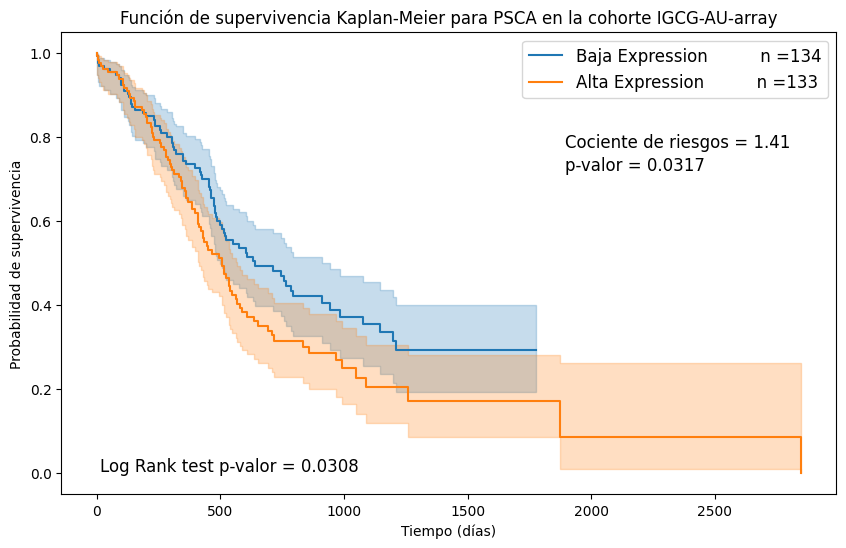

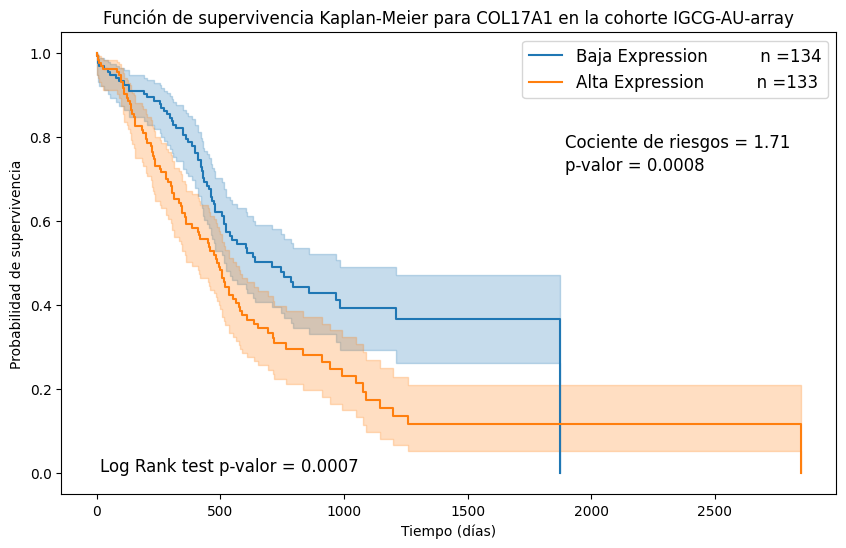

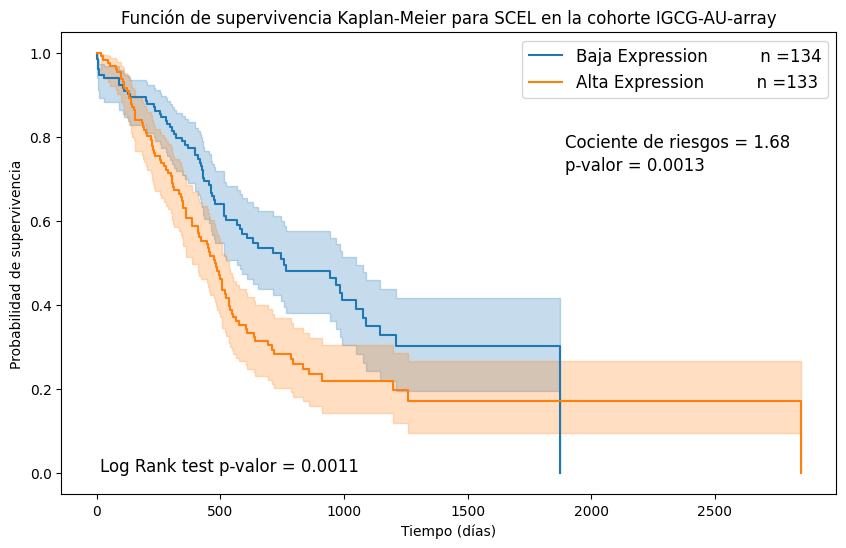

In [65]:
GraficaSupervivencia (datos.keys(), ['PSCA', 'COL17A1', 'SCEL'], logRank, COX)

In [66]:
Marcadores_significativos = ["PSCA", "SCEL", "COL17A1"]

#### 2.2. Análisis clínico de las cohortes y análisis COX multivariable

##### 2.2.1. Generación de las tablas completas con información clínica y expresión RNA

In [17]:
# Definir las funciones que van a ser utilizadas
def AbrirArchivo (Key):
    df = pd.read_csv("Clinical" + Key + '.csv')
    df = df.rename(columns={df.columns[0] : "ID_Paciente", df.columns[1]:"Tiempo", df.columns[2]:"Supervivencia"})
    return(df)

def GraficaSupervivencia (keys):
    Cohorte = pd.DataFrame(datos.get(keys))
    Cohorte = Cohorte.reset_index()
    Cohorte = Cohorte.rename(columns={Cohorte.columns[0] : "ID_Paciente", Cohorte.columns[1]:"Tiempo", Cohorte.columns[2]:"Supervivencia"})
    return(Cohorte)

Cohorte TCGA

In [18]:
TCGAClinica = AbrirArchivo("TCGA")
TCGAClinica = TCGAClinica.sort_values(by = "ID_Paciente")
TCGAClinica.head()

,ID_Paciente,Tiempo,Supervivencia,coef2a,coefscph12,age,gender,stage1,grade,coefscph12b,subtypemoffitt,coef7con,coef7cl
129,TCGA.2J.AAB6.01,293,1,1,1,75,1,0.0,0.0,1.439034,1,1.502889,1
21,TCGA.2J.AAB8.01,80,0,0,0,71,1,1.0,1.0,-0.020600,0,0.110186,1
102,TCGA.2J.AAB9.01,627,1,1,1,70,0,1.0,0.0,0.352618,1,0.152486,1
52,TCGA.2J.AABA.01,607,1,0,0,55,1,1.0,0.0,-0.470287,0,-0.600423,0
96,TCGA.2J.AABE.01,676,0,0,1,73,1,0.0,0.0,1.668766,0,1.273596,1


In [19]:
TCGAClinica = TCGAClinica[["ID_Paciente", "Tiempo", "Supervivencia", "age", "gender", "stage1", "grade", "subtypemoffitt"]]    
TCGAClinica = TCGAClinica.rename(columns={TCGAClinica.columns[3] : "Edad", TCGAClinica.columns[4]:"Sexo", TCGAClinica.columns[5]:"Estadío agrupado", TCGAClinica.columns[6]:"Grado agrupado", TCGAClinica.columns[7]:"Subtipo molecular"})
TCGAClinica.head()

,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Grado agrupado,Subtipo molecular
129,TCGA.2J.AAB6.01,293,1,75,1,0.0,0.0,1
21,TCGA.2J.AAB8.01,80,0,71,1,1.0,1.0,0
102,TCGA.2J.AAB9.01,627,1,70,0,1.0,0.0,1
52,TCGA.2J.AABA.01,607,1,55,1,1.0,0.0,0
96,TCGA.2J.AABE.01,676,0,73,1,0.0,0.0,0


In [20]:
TablaTCGA = GraficaSupervivencia("TCGA-seq")
TablaTCGA

,ID_Paciente,Tiempo,Supervivencia,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,TCGA.2J.AAB6.01,293,1,2.297025,0.096002,0.000000,6.305004,32.287120,205.355181,49.337882,...,0.315160,5.348758,8.599770,0.015360,9.244299,536.004610,6.483578,15.014722,0.746628,0.000000
1,TCGA.2J.AAB8.01,80,0,1.988100,0.493875,0.000000,8.951757,0.374457,432.498098,21.522691,...,0.958377,8.816501,8.425653,0.122919,11.454073,332.460793,7.690131,18.916415,3.020611,0.000000
2,TCGA.2J.AAB9.01,627,1,2.593508,0.220540,0.017890,5.669067,10.016139,514.282189,43.456376,...,1.094688,6.656577,6.711048,0.024700,7.668009,325.450251,7.093374,12.553404,0.747060,0.000000
3,TCGA.2J.AABA.01,607,1,3.708424,0.294523,0.000000,5.144273,20.767661,332.052500,37.252483,...,1.516058,7.807530,16.502740,0.043982,17.095512,295.889471,13.611275,26.468188,1.187701,0.065361
4,TCGA.2J.AABE.01,676,0,2.802831,0.045728,0.000000,6.570497,1.678084,337.799307,39.543163,...,1.546818,10.855597,11.042890,0.020486,9.650307,432.691154,7.855796,14.790268,1.726023,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,TCGA.XN.A8T3.01,951,0,4.349919,0.292959,0.000000,4.779043,0.011106,537.101395,37.494476,...,1.050219,6.221963,10.740537,0.016406,11.748465,318.256343,11.142176,21.117171,1.630324,0.000000
137,TCGA.XN.A8T5.01,720,0,4.293035,0.140353,0.099620,4.307428,0.266041,611.464252,30.158132,...,1.564276,10.025490,9.254145,0.058948,11.673897,390.370249,12.435455,18.143404,2.504518,0.000000
138,TCGA.YB.A89D.01,350,0,5.076589,1.008882,0.022733,4.687084,0.148738,659.457816,44.071512,...,1.004641,10.086219,6.703249,0.000000,11.788005,473.026588,8.188995,13.149101,1.118822,0.000000
139,TCGA.YY.A8LH.01,2016,0,2.032868,0.390515,0.083852,5.185709,0.174170,119.731796,14.958713,...,1.045207,8.871354,6.542335,0.000000,4.808089,259.650404,6.635721,9.165150,0.166744,0.000000


In [21]:
TCGA = pd.merge(TCGAClinica, TablaTCGA, on=['ID_Paciente', "Tiempo", "Supervivencia"])
print(TCGA.shape)
TCGA.head()

(141, 20334)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Grado agrupado,Subtipo molecular,A1BG,A1CF,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,TCGA.2J.AAB6.01,293,1,75,1,0.0,0.0,1,2.297025,0.096002,...,0.315160,5.348758,8.599770,0.015360,9.244299,536.004610,6.483578,15.014722,0.746628,0.000000
1,TCGA.2J.AAB8.01,80,0,71,1,1.0,1.0,0,1.988100,0.493875,...,0.958377,8.816501,8.425653,0.122919,11.454073,332.460793,7.690131,18.916415,3.020611,0.000000
2,TCGA.2J.AAB9.01,627,1,70,0,1.0,0.0,1,2.593508,0.220540,...,1.094688,6.656577,6.711048,0.024700,7.668009,325.450251,7.093374,12.553404,0.747060,0.000000
3,TCGA.2J.AABA.01,607,1,55,1,1.0,0.0,0,3.708424,0.294523,...,1.516058,7.807530,16.502740,0.043982,17.095512,295.889471,13.611275,26.468188,1.187701,0.065361
4,TCGA.2J.AABE.01,676,0,73,1,0.0,0.0,0,2.802831,0.045728,...,1.546818,10.855597,11.042890,0.020486,9.650307,432.691154,7.855796,14.790268,1.726023,0.000000


In [22]:
TCGA.to_csv('TCGAClinicaExp.csv', index=False)

Cohorte IGCG-AU-seq

In [23]:
AUClinica = AbrirArchivo("IGCG")
print(AUClinica.shape)
AUClinica.head()

(275, 8)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Grado agrupado,Estadío agrupado,Subtipo molecular
0,DO32823,522.0,1,59.0,0.0,0.0,NaN,NaN
1,DO32825,2848.0,1,77.0,0.0,0.0,1.0,0.0
2,DO32827,1778.0,0,58.0,1.0,0.0,NaN,NaN
3,DO32829,1874.0,1,78.0,1.0,0.0,NaN,NaN
4,DO32831,1715.0,0,49.0,0.0,1.0,0.0,1.0


In [24]:
TablaAUseq = GraficaSupervivencia("IGCG-AU-seq")
print(TablaAUseq.shape)
TablaAUseq.head()

(59, 21227)


,ID_Paciente,Tiempo,Supervivencia,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,...,ZNF587B,RAB11B-AS1,SPIB,ERVV-1,C10orf95-AS1,ZIM2,MIR1470,KCNQ1OT1,RNF225,EGLN2
0,DO32860,1259,1,46.518133,0.043857,98.711275,23.241363,5.329052,11.875111,148.765656,...,18.989886,5.460595,3.464287,0.000000,21.537766,0.218794,0.0,12.479457,0.134187,47.443532
1,DO32863,715,1,61.902894,0.065983,73.321550,11.704381,5.822802,7.290643,223.547305,...,7.981509,2.836338,0.906453,0.000000,8.352220,0.123443,0.0,3.269647,0.201888,41.496944
2,DO32875,348,1,93.287225,0.032581,110.460250,20.162811,14.107070,12.692274,140.178515,...,10.982284,4.636182,25.330459,0.059486,20.682612,0.040635,0.0,10.178653,0.299061,85.633412
3,DO32878,260,1,47.796547,0.000000,79.633456,13.098718,4.111204,5.594381,36.882762,...,6.885649,7.948237,0.920802,0.072521,8.959333,0.185774,0.0,4.869373,0.729186,48.870152
4,DO32900,768,1,87.561009,0.028971,85.903162,17.813563,7.199914,3.568012,334.661866,...,14.977515,4.466067,3.109333,0.000000,20.238496,0.397466,0.0,12.822182,0.177285,56.235582


In [25]:
AUseq = pd.merge(AUClinica, TablaAUseq, on=['ID_Paciente', "Tiempo", "Supervivencia"])
print(AUseq.shape)
AUseq.head()

(59, 21232)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Grado agrupado,Estadío agrupado,Subtipo molecular,TSPAN6,TNMD,...,ZNF587B,RAB11B-AS1,SPIB,ERVV-1,C10orf95-AS1,ZIM2,MIR1470,KCNQ1OT1,RNF225,EGLN2
0,DO32860,1259.0,1,57.0,1.0,0.0,1.0,0.0,46.518133,0.043857,...,18.989886,5.460595,3.464287,0.000000,21.537766,0.218794,0.0,12.479457,0.134187,47.443532
1,DO32863,715.0,1,60.0,1.0,1.0,1.0,0.0,61.902894,0.065983,...,7.981509,2.836338,0.906453,0.000000,8.352220,0.123443,0.0,3.269647,0.201888,41.496944
2,DO32875,348.0,1,69.0,1.0,1.0,1.0,0.0,93.287225,0.032581,...,10.982284,4.636182,25.330459,0.059486,20.682612,0.040635,0.0,10.178653,0.299061,85.633412
3,DO32878,260.0,1,69.0,0.0,1.0,1.0,0.0,47.796547,0.000000,...,6.885649,7.948237,0.920802,0.072521,8.959333,0.185774,0.0,4.869373,0.729186,48.870152
4,DO32900,768.0,1,51.0,1.0,1.0,1.0,0.0,87.561009,0.028971,...,14.977515,4.466067,3.109333,0.000000,20.238496,0.397466,0.0,12.822182,0.177285,56.235582


In [26]:
AUseq.to_csv('AUseqClinicaExp.csv', index=False)

Cohorte IGCG-AU-array

In [27]:
ICGC_ARRAYSClinica = AbrirArchivo("IGCG")
print(ICGC_ARRAYSClinica.shape)
ICGC_ARRAYSClinica.head()

(275, 8)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Grado agrupado,Estadío agrupado,Subtipo molecular
0,DO32823,522.0,1,59.0,0.0,0.0,NaN,NaN
1,DO32825,2848.0,1,77.0,0.0,0.0,1.0,0.0
2,DO32827,1778.0,0,58.0,1.0,0.0,NaN,NaN
3,DO32829,1874.0,1,78.0,1.0,0.0,NaN,NaN
4,DO32831,1715.0,0,49.0,0.0,1.0,0.0,1.0


In [28]:
TablaAUarray = GraficaSupervivencia("IGCG-AU-array")
print(TablaAUarray.shape)
TablaAUarray.head()

(267, 18809)


,ID_Paciente,Tiempo,Supervivencia,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,DO35009,787,1,3.331298,5.444442,11.374583,2.367607,1.945858,6.821118,3.828637,...,3.796488,2.880499,2.074888,3.384823,4.664532,1.656522,8.709023,9.203651,7.996083,7.962867
1,DO35057,485,0,3.997241,3.445481,9.458747,1.723085,1.918346,7.032319,3.921697,...,3.115030,2.416206,2.691390,4.092676,5.653491,1.770672,8.947058,9.512340,7.581785,6.318999
2,DO35073,764,0,2.489985,5.086388,8.777389,9.190203,2.014237,8.932572,3.408057,...,3.477820,2.379386,2.484966,3.980773,5.188866,1.548574,8.818331,10.193389,6.259196,7.133478
3,DO35033,107,1,2.961874,2.588270,9.376780,3.164469,2.507070,7.384684,2.644342,...,3.845142,3.308495,3.368152,3.636652,4.868134,1.919507,8.635117,8.995983,6.129114,8.080609
4,DO35041,155,1,3.197515,2.146641,9.834173,5.060053,2.261016,7.893801,3.199526,...,3.842389,3.553921,2.141802,3.532160,4.071013,1.846715,8.677426,9.463966,5.872450,8.370998


In [29]:
AUarrayCompleto = pd.merge(ICGC_ARRAYSClinica, TablaAUarray, on=['ID_Paciente', "Tiempo", "Supervivencia"])
print(AUarrayCompleto.shape)
AUarrayCompleto.head()

(267, 18814)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Grado agrupado,Estadío agrupado,Subtipo molecular,A1BG,A1CF,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,DO32823,522.0,1,59.0,0.0,0.0,NaN,NaN,3.733892,3.165097,...,3.258604,2.751397,2.968511,4.379493,4.997405,1.802900,9.204020,9.708605,7.009723,6.957023
1,DO32825,2848.0,1,77.0,0.0,0.0,1.0,0.0,4.486109,6.600279,...,4.399662,3.134297,2.175956,3.529960,3.146886,1.676103,8.613931,8.523744,4.263163,8.390478
2,DO32827,1778.0,0,58.0,1.0,0.0,NaN,NaN,3.074312,4.714273,...,3.540373,2.028905,2.353193,4.734109,3.331258,1.634316,8.638425,9.130336,4.844657,7.663479
3,DO32829,1874.0,1,78.0,1.0,0.0,NaN,NaN,3.672927,4.783298,...,4.204002,3.964951,2.750545,4.451987,4.716894,1.540969,8.895706,8.966492,5.647508,8.226279
4,DO32831,1715.0,0,49.0,0.0,1.0,0.0,1.0,2.222340,2.095891,...,3.862451,4.337430,3.313024,4.697841,4.755522,1.555114,8.660163,8.305630,5.883678,8.607176


In [30]:
ICGC_ARRAYClinica = AbrirArchivo("ICGC_ARRAYS")
print(ICGC_ARRAYClinica.shape)
ICGC_ARRAYClinica.head()

(125, 20)


,ID_Paciente,Tiempo,Supervivencia,icgc_sample_id,Age.at.Diagnosis.in.Years,AJCC.Pathology.Stage,Gender,HistoSubtype,Sample.type,Tumour.Grade,grade,stage2,gender,predictionsG.Subtype,treatment,chemotherapy,notreat,coefcph7,coefcph7clnt,moffittsub
0,DO32825,2848,1,SA407779,77.0,IIB,female,Intraductal Papillary Mucinous Neoplasm with i...,Primary tumour,2 - Moderately differentiated,0.0,1.0,0.0,classical,surgery,0,1,-0.744912,0,0
1,DO32833,56,1,SA407918,74.0,IIB,female,Pancreatic Ductal Adenocarcinoma,Primary tumour,2 - Moderately differentiated,0.0,1.0,0.0,classical,surgery,0,1,0.464058,1,0
2,DO32835,1209,1,SA407946,72.0,IIB,male,Intraductal Papillary Mucinous Neoplasm with i...,Cell line,2 - Moderately differentiated,0.0,1.0,1.0,classical,surgery,0,1,-0.208590,0,0
3,DO32837,399,1,SA408003,34.0,IIA,male,PDA - Undifferentiated carcinoma with osteocla...,Primary tumour,4 - Undifferentiated,1.0,0.0,1.0,classical,surgery,0,1,-0.759263,0,0
4,DO32843,1048,1,SA408106,60.0,IIB,female,Pancreatic Ductal Adenocarcinoma,Primary tumour,2 - Moderately differentiated,0.0,1.0,0.0,classical,surgery,0,1,-0.619998,0,0


In [31]:
ICGC_ARRAYSClin = ICGC_ARRAYClinica[["ID_Paciente", "Tiempo", "Supervivencia", "Age.at.Diagnosis.in.Years", "Gender", "stage2", "grade", "moffittsub"]]    
ICGC_ARRAYSClin = ICGC_ARRAYSClin.rename(columns={ICGC_ARRAYSClin.columns[3] : "Edad", ICGC_ARRAYSClin.columns[4]:"Sexo", ICGC_ARRAYSClin.columns[5]:"Estadío agrupado", ICGC_ARRAYSClin.columns[6]:"Grado agrupado", ICGC_ARRAYSClin.columns[7]:"Subtipo molecular"})
ICGC_ARRAYSClin['Sexo'] = ICGC_ARRAYSClin['Sexo'].replace({'male': 1, 'female': 0})
print(ICGC_ARRAYSClin.shape)
ICGC_ARRAYSClin.head()

(125, 8)


C:\Users\Sara\AppData\Local\Temp\ipykernel_7132\27184950.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ICGC_ARRAYSClin['Sexo'] = ICGC_ARRAYSClin['Sexo'].replace({'male': 1, 'female': 0})


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Grado agrupado,Subtipo molecular
0,DO32825,2848,1,77.0,0.0,1.0,0.0,0
1,DO32833,56,1,74.0,0.0,1.0,0.0,0
2,DO32835,1209,1,72.0,1.0,1.0,0.0,0
3,DO32837,399,1,34.0,1.0,0.0,1.0,0
4,DO32843,1048,1,60.0,0.0,1.0,0.0,0


In [32]:
AUarray = pd.merge(ICGC_ARRAYSClin, TablaAUarray, on=['ID_Paciente', "Tiempo", "Supervivencia"])
print(AUarray.shape)
AUarray.head()

(125, 18814)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Grado agrupado,Subtipo molecular,A1BG,A1CF,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,DO32825,2848,1,77.0,0.0,1.0,0.0,0,4.486109,6.600279,...,4.399662,3.134297,2.175956,3.529960,3.146886,1.676103,8.613931,8.523744,4.263163,8.390478
1,DO32833,56,1,74.0,0.0,1.0,0.0,0,3.782777,5.792833,...,3.846866,3.241346,2.315944,4.745813,4.114472,1.607233,8.652961,8.768862,5.664762,7.451202
2,DO32835,1209,1,72.0,1.0,1.0,0.0,0,2.408077,4.661117,...,3.459662,2.303770,2.215162,4.100062,4.513817,1.517811,9.152117,9.870171,6.810072,7.748490
3,DO32837,399,1,34.0,1.0,0.0,1.0,0,3.537787,2.092468,...,4.390631,2.659673,3.124757,3.211065,4.655843,1.700241,9.567213,9.365409,5.851211,8.722147
4,DO32843,1048,1,60.0,0.0,1.0,0.0,0,3.921122,7.008159,...,4.140578,3.534411,2.228521,5.354255,4.552003,1.670322,8.506996,8.746793,6.045323,8.219348


In [33]:
AUarray.to_csv('AUarrayClinicaExp.csv', index=False)

Cohorte IGCG-CA-seq

In [34]:
CAClinica = AbrirArchivo("CA")
print(CAClinica.shape)
CAClinica.sort_values(by = "ID_Paciente")

(163, 11)


,ID_Paciente,Tiempo,Supervivencia,donor_sex,donor_age_at_diagnosis,donor_tumour_stage_at_diagnosis,scoresicgca7,scoresicgca7cl,scoresicgca3,scoresicgca3cl,subtypemoffitt
46,DO221539,1733,0,1,49.0,1.0,-1.075905,0,-5.769198,0,0
98,DO221540,290,1,1,56.0,1.0,0.126180,0,-6.160696,0,0
51,DO221541,195,1,1,75.0,0.0,-1.312662,0,-5.391889,0,0
82,DO221542,375,0,1,60.0,0.0,-1.013941,0,-6.254444,0,1
57,DO221543,2045,0,1,54.0,1.0,-1.102899,0,-5.478893,0,0
...,...,...,...,...,...,...,...,...,...,...,...
154,DO51542,369,1,0,54.0,1.0,0.197614,0,-5.398846,0,0
88,DO51543,1431,1,0,76.0,NaN,0.863083,1,-5.598055,0,0
157,DO51545,190,1,0,75.0,0.0,-1.390840,0,-5.090596,0,1
100,DO51548,2177,0,0,55.0,1.0,0.493796,1,-5.025564,1,0


In [35]:
CAClinica = CAClinica[["ID_Paciente", "Tiempo", "Supervivencia", "donor_age_at_diagnosis", "donor_sex", "donor_tumour_stage_at_diagnosis", "subtypemoffitt"]]    
CAClinica = CAClinica.rename(columns={CAClinica.columns[3] : "Edad", CAClinica.columns[4]:"Sexo", CAClinica.columns[5]:"Estadío agrupado", CAClinica.columns[6]:"Subtipo molecular"})
print(CAClinica.shape)
CAClinica.head()

(163, 7)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Subtipo molecular
0,DO49421,385,1,74.0,0,1.0,0
1,DO49433,456,1,48.0,1,1.0,1
2,DO49478,653,0,81.0,1,0.0,0
3,DO51468,1083,1,69.0,1,1.0,0
4,DO51480,228,1,41.0,0,1.0,0


In [36]:
CAClinica2 = pd.read_csv("specimenCA.tsv", delimiter ="\t")
print(CAClinica2.columns)
CAClinica2.head()

Index(['icgc_specimen_id', 'project_code', 'study_specimen_involved_in',
       'submitted_specimen_id', 'icgc_donor_id', 'submitted_donor_id',
       'specimen_type', 'specimen_type_other', 'specimen_interval',
       'specimen_donor_treatment_type', 'specimen_donor_treatment_type_other',
       'specimen_processing', 'specimen_processing_other', 'specimen_storage',
       'specimen_storage_other', 'tumour_confirmed', 'specimen_biobank',
       'specimen_biobank_id', 'specimen_available', 'tumour_histological_type',
       'tumour_grading_system', 'tumour_grade', 'tumour_grade_supplemental',
       'tumour_stage_system', 'tumour_stage', 'tumour_stage_supplemental',
       'digital_image_of_stained_section', 'percentage_cellularity',
       'level_of_cellularity'],
      dtype='object')


,icgc_specimen_id,project_code,study_specimen_involved_in,submitted_specimen_id,icgc_donor_id,submitted_donor_id,specimen_type,specimen_type_other,specimen_interval,specimen_donor_treatment_type,...,tumour_histological_type,tumour_grading_system,tumour_grade,tumour_grade_supplemental,tumour_stage_system,tumour_stage,tumour_stage_supplemental,digital_image_of_stained_section,percentage_cellularity,level_of_cellularity
0,SP78201,PACA-CA,NaN,PCSI_0103_Pa_P,DO35083,PCSI_0103,Primary tumour - solid tissue,NaN,NaN,no treatment,...,Mar-00,AJCC,G1,NaN,TNM,T3N1bM0,IIB,NaN,NaN,NaN
1,SP77813,PACA-CA,NaN,PCSI_0103_Ly_R,DO35083,PCSI_0103,Normal - blood derived,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP125746,PACA-CA,PCAWG,PCSI_0103_Pa_P_526,DO35083,PCSI_0103,Primary tumour - other,Enriched by Laser Capture Microdissection,49.0,no treatment,...,8500/3,WHO,Moderately differentiated,NaN,AJCC/UICC TNM,IIB,NaN,NaN,NaN,NaN
3,SP113881,PACA-CA,PCAWG,PCSI_0103_Si_R,DO35083,PCSI_0103,Normal - solid tissue,NaN,49.0,no treatment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP196587,PACA-CA,NaN,MPCC_0024_Pa_C,DO35081,MPCC_0024,Cell line - derived from tumour,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
CAClinica3 = CAClinica2[["icgc_donor_id", "tumour_grade"]]
CAClinica3 = CAClinica3.rename(columns={CAClinica3.columns[0] : "ID_Paciente", CAClinica3.columns[1]:"Grado"})
CAClinica3['Grado'] = CAClinica3['Grado'].fillna(CAClinica3['ID_Paciente'])
# Eliminar las filas donde 'ID' y 'Columna2' tienen el mismo valor
CAClinica3 = CAClinica3.query('ID_Paciente != Grado')
CAClinica3.loc[(CAClinica3['Grado'] == "Well differentiated") | (CAClinica3['Grado'] == "Moderately differentiated") , 'Grado agrupado'] = 0
CAClinica3.loc[(CAClinica3['Grado'] == "Poorly differentiated")  | (CAClinica3['Grado'] == "Undifferentiated"), 'Grado agrupado'] = 1
CAClinica3 = CAClinica3.dropna(subset=['Grado agrupado'])
CAClinica3 = CAClinica3.drop_duplicates()
CAClinica3.drop('Grado', axis=1, inplace=True)
CAClinica3.head()

,ID_Paciente,Grado agrupado
2,DO35083,0.0
6,DO35082,0.0
9,DO35085,0.0
14,DO35236,0.0
17,DO35230,0.0


In [38]:
CAClinica["Grado agrupado"] = CAClinica['ID_Paciente'].map(dict(zip(CAClinica3['ID_Paciente'], CAClinica3['Grado agrupado'])))
print(CAClinica.shape)
CAClinica.head()

(163, 8)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Subtipo molecular,Grado agrupado
0,DO49421,385,1,74.0,0,1.0,0,1.0
1,DO49433,456,1,48.0,1,1.0,1,1.0
2,DO49478,653,0,81.0,1,0.0,0,0.0
3,DO51468,1083,1,69.0,1,1.0,0,1.0
4,DO51480,228,1,41.0,0,1.0,0,1.0


In [39]:
TablaCA = GraficaSupervivencia("IGCG-CA-seq")
print(TablaCA.shape)
TablaCA.head()

(163, 20440)


,ID_Paciente,Tiempo,Supervivencia,OR4F5,LINC01128,FAM41C,LINC02593,SAMD11,NOC2L,KLHL17,...,PRY,TTTY17A,TTTY4,BPY2,DAZ1,DAZ2,DAZ3,DAZ4,CDY1,TTTY3
0,DO49421,385,1,0.0,0.507358,0.00000,0.000000,1.263333,60.433251,8.802793,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,DO49433,456,1,0.0,0.083610,0.00000,1.556388,1.387933,36.990753,6.695304,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,DO49478,653,0,0.0,0.652367,0.00000,0.000000,1.082939,79.925903,25.249471,...,0.0,0.0,0.0,0.0,1.698045,1.827681,0.985857,0.200283,0.0,0.0
3,DO51468,1083,1,0.0,0.180139,0.00000,0.000000,3.708007,64.432169,12.501802,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,DO51480,228,1,0.0,0.603468,0.29691,0.000000,3.824922,110.528983,24.015827,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [40]:
CA = pd.merge(CAClinica, TablaCA, on=['ID_Paciente', "Tiempo", "Supervivencia"])
print(CA.shape)
CA.head()

(163, 20445)


,ID_Paciente,Tiempo,Supervivencia,Edad,Sexo,Estadío agrupado,Subtipo molecular,Grado agrupado,OR4F5,LINC01128,...,PRY,TTTY17A,TTTY4,BPY2,DAZ1,DAZ2,DAZ3,DAZ4,CDY1,TTTY3
0,DO49421,385,1,74.0,0,1.0,0,1.0,0.0,0.507358,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,DO49433,456,1,48.0,1,1.0,1,1.0,0.0,0.083610,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,DO49478,653,0,81.0,1,0.0,0,0.0,0.0,0.652367,...,0.0,0.0,0.0,0.0,1.698045,1.827681,0.985857,0.200283,0.0,0.0
3,DO51468,1083,1,69.0,1,1.0,0,1.0,0.0,0.180139,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,DO51480,228,1,41.0,0,1.0,0,1.0,0.0,0.603468,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [41]:
CA.to_csv('CAClinicaExp.csv', index=False)

##### 2.2.2. Análisis de los datos clínicos

In [42]:
# Se define una función para analizar los datos clínicos de cada cohorte

def ClinicalAnalisis (Tabla):
    print('######################################################################################################################\n')
    print("N = ", Tabla.shape[0], "\n")
    
    # Evento
    print("Análsis Evento: 0 = vivo, 1 = muerto:")
    print (Tabla["Supervivencia"].value_counts())
    print("Hay", Tabla['Supervivencia'].isna().sum(), "valores NA \n")

    # Edad
    print("Análisis Edad:")
    print("Mayor de 65:", (Tabla['Edad'] > 65).sum())
    print("Menor o igual que 65:", (Tabla['Edad'] <= 65).sum())
    print("Hay", Tabla['Edad'].isna().sum(), "valores NA \n")

    #Sexo
    print("Análsis Sexo: 0 = mujer, 1 = hombre:")
    print(Tabla["Sexo"].value_counts())
    print("Hay", Tabla['Sexo'].isna().sum(), "valores NA \n")

    # Estadío agrupado
    print("Análisis Estadío agrupado: 0 = IA IB y IIA, 1 = IIB,III y IV")
    print(Tabla["Estadío agrupado"].value_counts())
    print("Hay", Tabla['Estadío agrupado'].isna().sum(), "valores NA \n")

    # Grado agrupado
    print("Análisis Grado agrupado: 0 = 1 y 2, 1 = 3 y 4")
    print(Tabla["Grado agrupado"].value_counts())
    print("Hay", Tabla['Grado agrupado'].isna().sum(), "valores NA \n")

    # Subtype motif
    print("Análisis subtipo molecular: 0 = Clásico y 1 = Basal")
    print(Tabla["Subtipo molecular"].value_counts())
    print("Hay", Tabla['Subtipo molecular'].isna().sum(), "valores NA \n")

    print('######################################################################################################################\n')

In [43]:
# Análisis para la cohorte TCGA
ClinicalAnalisis(TCGA)

# Análisis para la cohorte CA
ClinicalAnalisis(CA)

# Análisis para la cohorte AUseq
ClinicalAnalisis(AUseq)

# Análisis para la cohorte AUarray
ClinicalAnalisis(AUarrayCompleto) # Con todos los NaN (no contiene los datos clínicos relevantes para el COX multivariable)
ClinicalAnalisis(AUarray) # El utilizado para el análisis posterior


######################################################################################################################

N =  141 

Análsis Evento: 0 = vivo, 1 = muerto:
Supervivencia
1    81
0    60
Name: count, dtype: int64
Hay 0 valores NA 

Análisis Edad:
Mayor de 65: 70
Menor o igual que 65: 71
Hay 0 valores NA 

Análsis Sexo: 0 = mujer, 1 = hombre:
Sexo
1    74
0    67
Name: count, dtype: int64
Hay 0 valores NA 

Análisis Estadío agrupado: 0 = IA IB y IIA, 1 = IIB,III y IV
Estadío agrupado
1.0    105
0.0     35
Name: count, dtype: int64
Hay 1 valores NA 

Análisis Grado agrupado: 0 = 1 y 2, 1 = 3 y 4
Grado agrupado
0.0    100
1.0     40
Name: count, dtype: int64
Hay 1 valores NA 

Análisis subtipo molecular: 0 = Clásico y 1 = Basal
Subtipo molecular
0    107
1     34
Name: count, dtype: int64
Hay 0 valores NA 

######################################################################################################################

####################################################

##### 2.2.3. Análisis COX multivariable de los marcadores

In [44]:
def AnalisisCox(Cohorte, Proteinas_interesantes, Key):
        Resultados = pd.DataFrame()
        columnas_coincidentes_df = pd.DataFrame()  # Define the DataFrame for coincident columns
        Listado_proteinas_levels = []
        for proteina in Proteinas_interesantes:
            if proteina in Cohorte.columns:
                columnas_coincidentes_df[proteina] = Cohorte[proteina].copy()
        Cohorte_Limpio = pd.concat([Cohorte.iloc[:, :10], columnas_coincidentes_df], axis=1)
        #print(Cohorte_Limpio)
        for Proteina in Cohorte_Limpio.columns[10:]:  
            Mediana = Cohorte_Limpio[Proteina].median()
            Cohorte_Limpio.loc[:, Proteina + "_levels"] = 0
            Cohorte_Limpio.loc[Cohorte_Limpio[Proteina] > Mediana, (Proteina + "_levels")] = 1
            Listado_proteinas_levels.append(Proteina + "_levels")
        for Proteina_Level in Listado_proteinas_levels:
            CohorteCox = Cohorte_Limpio[['ID_Paciente', "Tiempo", "Supervivencia", "Edad", "Sexo", "Grado agrupado", "Estadío agrupado", Proteina_Level]].copy()
            # Establecer la columna "ID_Paciente" como índice comenzando desde la segunda fila y omitiendo el encabezado
            CohorteCox.index = CohorteCox["ID_Paciente"].iloc[0:]
            # Eliminar la columna "ID_Paciente"
            CohorteCox.drop(columns=["ID_Paciente"], inplace=True)
            media_edad = CohorteCox["Edad"].mean()
            media_sexo = CohorteCox["Sexo"].mean()
            media_grado = CohorteCox["Grado agrupado"].mean()
            media_estadío = CohorteCox["Estadío agrupado"].mean()
            # Llenar los valores NaN en la columna Edad y sexo con el valor medio calculado
            CohorteCox["Edad"] = CohorteCox["Edad"].fillna(media_edad)
            CohorteCox["Sexo"] = CohorteCox["Sexo"].fillna(media_sexo)
            CohorteCox["Grado agrupado"] = CohorteCox["Grado agrupado"].fillna(media_grado)
            CohorteCox["Estadío agrupado"] = CohorteCox["Estadío agrupado"].fillna(media_estadío)
                  
            cph = CoxPHFitter()
            cph.fit(CohorteCox, 'Tiempo', event_col='Supervivencia')
            print("\033[1m Análsis log cohorte " + Key + " Proteina " + Proteina_Level + "\033[1m")
            cph.print_summary()
            print("\n")
            Exp = cph.summary['exp(coef)']
            pval = cph.summary['p']
            Coef_lox = cph.summary['exp(coef) lower 95%']
            Coef_high = cph.summary['exp(coef) upper 95%']
            # Edad
            Resultados.loc[Proteina_Level + " Edad", "HR"] = round(Exp["Edad"], 2)
            Resultados.loc[Proteina_Level + " Edad", 'p-value'] = round(pval["Edad"], 4)
            Resultados.loc[Proteina_Level + " Edad", "Coef_low"] = round(Coef_lox["Edad"], 2)
            Resultados.loc[Proteina_Level + " Edad", "Coef_high"] = round(Coef_high["Edad"], 2)
            # Sexo
            Resultados.loc[Proteina_Level + " Sexo", "HR"] = round(Exp["Sexo"], 2)
            Resultados.loc[Proteina_Level + " Sexo", "p-value"] = round(pval["Sexo"], 4)
            Resultados.loc[Proteina_Level + " Sexo", "Coef_low"] = round(Coef_lox["Sexo"], 2)
            Resultados.loc[Proteina_Level + " Sexo", "Coef_high"] = round(Coef_high["Sexo"], 2)
            # Estadío
            Resultados.loc[Proteina_Level + " Estadío", "HR"] = round(Exp["Estadío agrupado"], 2)
            Resultados.loc[Proteina_Level + " Estadío", "p-value"] = round(pval["Estadío agrupado"], 4)    
            Resultados.loc[Proteina_Level + " Estadío", "Coef_low"] = round(Coef_lox["Estadío agrupado"], 2)
            Resultados.loc[Proteina_Level + " Estadío", "Coef_high"] = round(Coef_high["Estadío agrupado"], 2)   
            # Grado
            Resultados.loc[Proteina_Level + " Grado", "HR"] = round(Exp["Grado agrupado"], 2)
            Resultados.loc[Proteina_Level + " Grado", "p-value"] = round(pval["Grado agrupado"], 4)
            Resultados.loc[Proteina_Level + " Grado", "Coef_low"] = round(Coef_lox["Grado agrupado"], 2)
            Resultados.loc[Proteina_Level + " Grado", "Coef_high"] = round(Coef_high["Grado agrupado"], 2)
            #Proteina
            Resultados.loc[Proteina_Level + " Expresión", "HR"] = round(Exp[Proteina_Level], 2)
            Resultados.loc[Proteina_Level + " Expresión", "p-value"] = round(pval[Proteina_Level], 4)
            Resultados.loc[Proteina_Level + " Expresión", "Coef_low"] = round(Coef_lox[Proteina_Level], 2)
            Resultados.loc[Proteina_Level + " Expresión", "Coef_high"] = round(Coef_high[Proteina_Level], 2)

        Resultados.index = Resultados.index.str.replace(r'_levels', '')
        
        return(Resultados)

In [45]:
# COX multivariable cohorte TCGA
TCGACox = AnalisisCox(TCGA, Marcadores_significativos, "TCGA")

# COX multivariable cohorte CA
CACox = AnalisisCox(CA, Marcadores_significativos, "ICGC-CA")

# COX multivariable cohorte AUseq
AUseqCox = AnalisisCox(AUseq, Marcadores_significativos, "IGCG-AU-seq")

# COX multivariable cohorte AUarray
AUarrayCox = AnalisisCox(AUarray, Marcadores_significativos, "ICGC-AU-array")

 Análsis log cohorte TCGA Proteina PSCA_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -327.01
         time fit was run = 2024-06-26 18:10:38 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.02      1.02      0.01           -0.01            0.04                0.99                1.04
Sexo             -0.27      0.76      0.23           -0.72            0.18                0.49                1.20
Grado agrupado    0.32      1.37      0.25           -0.17            0.80                0.85                2.23
Estadío agrupado  0.38      1.47      0.30           -0.21            0.98                0.81                2.65
PSCA_levels       0.62      1.86      0.24            0.16            1.09                1.17                2.96

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  1.39 0.17      2.59
Sexo                0.00 -1.17 0.24      2.05
Grado agrupado      0.00  1.29 0.20      2.34
Estadío agrupado    0.00  1.28 0.20      2.31
PSCA_levels         0.00  2.63 0.01      6.88
---
Concordance = 0.60
Partial AIC = 664.01
log-likelihood ratio test = 12.60 on 5 df
-log2(p) of ll-ratio test = 5.19



 Análsis log cohorte TCGA Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -329.96
         time fit was run = 2024-06-26 18:10:38 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.02      1.02      0.01           -0.01            0.04                0.99                1.04
Sexo             -0.26      0.77      0.23           -0.71            0.19                0.49                1.21
Grado agrupado    0.29      1.34      0.25           -0.20            0.78                0.82                2.19
Estadío agrupado  0.22      1.24      0.29           -0.36            0.79                0.70                2.20
SCEL_levels       0.24      1.28      0.23           -0.21            0.70                0.81                2.02

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  1.46 0.14      2.80
Sexo                0.00 -1.12 0.26      1.94
Grado agrupado      0.00  1.16 0.25      2.02
Estadío agrupado    0.00  0.73 0.46      1.11
SCEL_levels         0.00  1.05 0.29      1.77
---
Concordance = 0.59
Partial AIC = 669.91
log-likelihood ratio test = 6.70 on 5 df
-log2(p) of ll-ratio test = 2.03



 Análsis log cohorte TCGA Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 141 total observations, 60 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 81
   partial log-likelihood = -326.58
         time fit was run = 2024-06-26 18:10:38 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.02      1.02      0.01           -0.00            0.04                1.00                1.04
Sexo             -0.40      0.67      0.24           -0.86            0.07                0.42                1.07
Grado agrupado    0.24      1.28      0.25           -0.24            0.73                0.79                2.07
Estadío agrupado  0.24      1.27      0.29           -0.34            0.81                0.71                2.25
COL17A1_levels    0.66      1.94      0.24            0.20            1.13                1.22                3.10

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  1.81 0.07      3.85
Sexo                0.00 -1.67 0.10      3.39
Grado agrupado      0.00  0.99 0.32      1.63
Estadío agrupado    0.00  0.80 0.42      1.25
COL17A1_levels      0.00  2.79 0.01      7.57
---
Concordance = 0.61
Partial AIC = 663.16
log-likelihood ratio test = 13.45 on 5 df
-log2(p) of ll-ratio test = 5.68



 Análsis log cohorte ICGC-CA Proteina PSCA_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -561.12
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.00      1.00      0.01           -0.01            0.02                0.99                1.02
Sexo              0.10      1.11      0.18           -0.25            0.45                0.78                1.58
Grado agrupado   -0.06      0.94      0.21           -0.47            0.35                0.63                1.42
Estadío agrupado  0.13      1.14      0.22           -0.29            0.56                0.75                1.75
PSCA_levels       0.43      1.54      0.18            0.08            0.79                1.08                2.21

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  0.39 0.70      0.52
Sexo                0.00  0.58 0.56      0.83
Grado agrupado      0.00 -0.29 0.78      0.37
Estadío agrupado    0.00  0.61 0.54      0.89
PSCA_levels         0.00  2.39 0.02      5.88
---
Concordance = 0.55
Partial AIC = 1132.23
log-likelihood ratio test = 6.42 on 5 df
-log2(p) of ll-ratio test = 1.90



 Análsis log cohorte ICGC-CA Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -555.78
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.00      1.00      0.01           -0.01            0.02                0.99                1.02
Sexo              0.13      1.14      0.18           -0.22            0.48                0.80                1.61
Grado agrupado    0.02      1.02      0.20           -0.37            0.42                0.69                1.51
Estadío agrupado  0.31      1.36      0.22           -0.12            0.73                0.89                2.08
SCEL_levels       0.76      2.13      0.19            0.39            1.12                1.47                3.07

                  cmp to    z      p  -log2(p)
covariate                                     
Edad                0.00 0.32   0.75      0.42
Sexo                0.00 0.72   0.47      1.09
Grado agrupado      0.00 0.10   0.92      0.12
Estadío agrupado    0.00 1.41   0.16      2.66
SCEL_levels         0.00 4.03 <0.005     14.14
---
Concordance = 0.60
Partial AIC = 1121.56
log-likelihood ratio test = 17.09 on 5 df
-log2(p) of ll-ratio test = 7.85



 Análsis log cohorte ICGC-CA Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 163 total observations, 32 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 131
   partial log-likelihood = -560.58
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Sexo              0.13      1.14      0.18           -0.22            0.48                0.80                1.62
Grado agrupado   -0.01      0.99      0.20           -0.40            0.39                0.67                1.48
Estadío agrupado  0.36      1.43      0.23           -0.09            0.80                0.92                2.24
COL17A1_levels    0.50      1.66      0.19            0.12            0.88                1.13                2.42

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  0.20 0.84      0.25
Sexo                0.00  0.72 0.47      1.09
Grado agrupado      0.00 -0.03 0.98      0.03
Estadío agrupado    0.00  1.58 0.11      3.13
COL17A1_levels      0.00  2.60 0.01      6.74
---
Concordance = 0.57
Partial AIC = 1131.16
log-likelihood ratio test = 7.49 on 5 df
-log2(p) of ll-ratio test = 2.42



 Análsis log cohorte IGCG-AU-seq Proteina PSCA_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -117.01
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.00      1.00      0.02           -0.03            0.03                0.97                1.04
Sexo             -0.30      0.74      0.38           -1.04            0.44                0.36                1.55
Grado agrupado    0.66      1.94      0.37           -0.06            1.39                0.94                4.01
Estadío agrupado  0.50      1.65      0.46           -0.40            1.41                0.67                4.08
PSCA_levels       0.39      1.48      0.38           -0.35            1.13                0.70                3.10

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  0.05 0.96      0.06
Sexo                0.00 -0.79 0.43      1.22
Grado agrupado      0.00  1.79 0.07      3.77
Estadío agrupado    0.00  1.09 0.28      1.86
PSCA_levels         0.00  1.03 0.30      1.72
---
Concordance = 0.64
Partial AIC = 244.03
log-likelihood ratio test = 7.71 on 5 df
-log2(p) of ll-ratio test = 2.53



 Análsis log cohorte IGCG-AU-seq Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -115.96
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.00      1.00      0.02           -0.03            0.04                0.97                1.04
Sexo             -0.24      0.79      0.38           -0.97            0.50                0.38                1.65
Grado agrupado    0.51      1.66      0.39           -0.25            1.26                0.78                3.54
Estadío agrupado  0.66      1.94      0.47           -0.26            1.59                0.77                4.88
SCEL_levels       0.70      2.01      0.40           -0.08            1.48                0.92                4.38

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  0.19 0.85      0.24
Sexo                0.00 -0.62 0.53      0.91
Grado agrupado      0.00  1.32 0.19      2.42
Estadío agrupado    0.00  1.42 0.16      2.67
SCEL_levels         0.00  1.75 0.08      3.65
---
Concordance = 0.64
Partial AIC = 241.93
log-likelihood ratio test = 9.81 on 5 df
-log2(p) of ll-ratio test = 3.63



 Análsis log cohorte IGCG-AU-seq Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 59 total observations, 22 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 37
   partial log-likelihood = -115.65
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.01      1.01      0.02           -0.02            0.05                0.98                1.05
Sexo             -0.46      0.63      0.36           -1.17            0.25                0.31                1.29
Grado agrupado    0.73      2.07      0.36            0.02            1.43                1.02                4.19
Estadío agrupado  0.53      1.70      0.46           -0.38            1.44                0.69                4.23
COL17A1_levels    0.69      1.99      0.36           -0.02            1.39                0.98                4.03

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  0.69 0.49      1.02
Sexo                0.00 -1.26 0.21      2.26
Grado agrupado      0.00  2.01 0.04      4.49
Estadío agrupado    0.00  1.15 0.25      2.00
COL17A1_levels      0.00  1.92 0.06      4.18
---
Concordance = 0.64
Partial AIC = 241.30
log-likelihood ratio test = 10.44 on 5 df
-log2(p) of ll-ratio test = 3.97



 Análsis log cohorte ICGC-AU-array Proteina PSCA_levels


<lifelines.CoxPHFitter: fitted with 125 total observations, 39 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 125
number of events observed = 86
   partial log-likelihood = -342.87
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.03      1.03      0.01           -0.00            0.05                1.00                1.05
Sexo              0.16      1.17      0.24           -0.32            0.63                0.73                1.88
Grado agrupado    0.61      1.84      0.23            0.15            1.07                1.16                2.91
Estadío agrupado  0.75      2.12      0.28            0.19            1.31                1.21                3.70
PSCA_levels      -0.04      0.96      0.23           -0.49            0.41                0.61                1.51

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  1.94 0.05      4.26
Sexo                0.00  0.64 0.52      0.94
Grado agrupado      0.00  2.59 0.01      6.70
Estadío agrupado    0.00  2.64 0.01      6.91
PSCA_levels         0.00 -0.17 0.87      0.20
---
Concordance = 0.62
Partial AIC = 695.74
log-likelihood ratio test = 19.53 on 5 df
-log2(p) of ll-ratio test = 9.35



 Análsis log cohorte ICGC-AU-array Proteina SCEL_levels


<lifelines.CoxPHFitter: fitted with 125 total observations, 39 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 125
number of events observed = 86
   partial log-likelihood = -342.85
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.03      1.03      0.01           -0.00            0.05                1.00                1.05
Sexo              0.17      1.18      0.24           -0.29            0.63                0.74                1.88
Grado agrupado    0.61      1.85      0.24            0.15            1.08                1.16                2.94
Estadío agrupado  0.74      2.10      0.28            0.19            1.30                1.21                3.66
SCEL_levels      -0.06      0.94      0.22           -0.50            0.38                0.61                1.46

                  cmp to     z    p  -log2(p)
covariate                                    
Edad                0.00  1.96 0.05      4.32
Sexo                0.00  0.71 0.48      1.07
Grado agrupado      0.00  2.60 0.01      6.73
Estadío agrupado    0.00  2.62 0.01      6.82
SCEL_levels         0.00 -0.27 0.79      0.34
---
Concordance = 0.61
Partial AIC = 695.70
log-likelihood ratio test = 19.57 on 5 df
-log2(p) of ll-ratio test = 9.38



 Análsis log cohorte ICGC-AU-array Proteina COL17A1_levels


<lifelines.CoxPHFitter: fitted with 125 total observations, 39 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 125
number of events observed = 86
   partial log-likelihood = -339.66
         time fit was run = 2024-06-26 18:10:39 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Edad              0.03      1.03      0.01            0.00            0.05                1.00                1.06
Sexo              0.16      1.18      0.24           -0.30            0.63                0.74                1.88
Grado agrupado    0.71      2.03      0.24            0.23            1.18                1.26                3.25
Estadío agrupado  0.61      1.85      0.29            0.05            1.18                1.05                3.25
COL17A1_levels    0.58      1.78      0.23            0.13            1.03                1.14                2.79

                  cmp to    z      p  -log2(p)
covariate                                     
Edad                0.00 2.20   0.03      5.18
Sexo                0.00 0.69   0.49      1.03
Grado agrupado      0.00 2.93 <0.005      8.20
Estadío agrupado    0.00 2.14   0.03      4.94
COL17A1_levels      0.00 2.54   0.01      6.48
---
Concordance = 0.65
Partial AIC = 689.32
log-likelihood ratio test = 25.95 on 5 df
-log2(p) of ll-ratio test = 13.42

In [46]:
TCGACox

,HR,p-value,Coef_low,Coef_high
PSCA Edad,1.02,0.1661,0.99,1.04
PSCA Sexo,0.76,0.2410,0.49,1.20
PSCA Estadío,1.47,0.2013,0.81,2.65
PSCA Grado,1.37,0.1977,0.85,2.23
PSCA Expresión,1.86,0.0085,1.17,2.96
SCEL Edad,1.02,0.1432,0.99,1.04
SCEL Sexo,0.77,0.2613,0.49,1.21
SCEL Estadío,1.24,0.4624,0.70,2.20
SCEL Grado,1.34,0.2474,0.82,2.19
SCEL Expresión,1.28,0.2937,0.81,2.02


In [47]:
CACox

,HR,p-value,Coef_low,Coef_high
PSCA Edad,1.00,0.6963,0.99,1.02
PSCA Sexo,1.11,0.5631,0.78,1.58
PSCA Estadío,1.14,0.5415,0.75,1.75
PSCA Grado,0.94,0.7752,0.63,1.42
PSCA Expresión,1.54,0.0170,1.08,2.21
SCEL Edad,1.00,0.7461,0.99,1.02
SCEL Sexo,1.14,0.4690,0.80,1.61
SCEL Estadío,1.36,0.1583,0.89,2.08
SCEL Grado,1.02,0.9201,0.69,1.51
SCEL Expresión,2.13,0.0001,1.47,3.07


In [48]:
AUseqCox

,HR,p-value,Coef_low,Coef_high
PSCA Edad,1.00,0.9565,0.97,1.04
PSCA Sexo,0.74,0.4294,0.36,1.55
PSCA Estadío,1.65,0.2751,0.67,4.08
PSCA Grado,1.94,0.0732,0.94,4.01
PSCA Expresión,1.48,0.3039,0.70,3.10
SCEL Edad,1.00,0.8464,0.97,1.04
SCEL Sexo,0.79,0.5321,0.38,1.65
SCEL Estadío,1.94,0.1570,0.77,4.88
SCEL Grado,1.66,0.1873,0.78,3.54
SCEL Expresión,2.01,0.0799,0.92,4.38


In [49]:
AUarrayCox

,HR,p-value,Coef_low,Coef_high
PSCA Edad,1.03,0.0522,1.00,1.05
PSCA Sexo,1.17,0.5220,0.73,1.88
PSCA Estadío,2.12,0.0083,1.21,3.70
PSCA Grado,1.84,0.0096,1.16,2.91
PSCA Expresión,0.96,0.8684,0.61,1.51
SCEL Edad,1.03,0.0502,1.00,1.05
SCEL Sexo,1.18,0.4776,0.74,1.88
SCEL Estadío,2.10,0.0088,1.21,3.66
SCEL Grado,1.85,0.0094,1.16,2.94
SCEL Expresión,0.94,0.7907,0.61,1.46


Representación gráfica en forest plot del análisis COX multivariable

In [50]:
def ForestPlot (ResultadoCox, cohorte):
    ResultadoCox = ResultadoCox.iloc[::-1].copy()
    nuevos_indices = []
    # Iterar fila por fila
    for indice_actual in ResultadoCox.index:
        # Obtener el contenido correspondiente al índice
        contenido = ResultadoCox.loc[indice_actual, 'p-value']
        # Combina el índice actual con el contenido y agrega el resultado a la lista de nuevos índices
        nuevos_indices.append(f"{indice_actual}\n{"p-valor " + str(contenido)}")
        # Asignar la lista de nuevos índices al índice del DataFrame
    ResultadoCox.index = nuevos_indices
    colores = {'PSCA': 'royalblue', 'SCEL': 'forestgreen', 'COL17A1': 'coral'}
    ResultadoCox["Colores"] = [colores[columna.split(' ')[0]] for columna in ResultadoCox.index]
    for Proteina in ["PSCA", "SCEL", "COL17A1"]:
        resultado_filtrado = ResultadoCox[ResultadoCox.index.str.contains(Proteina)]
        plt.figure(figsize=(6, 4))
        plt.errorbar(resultado_filtrado['HR'], range(len(resultado_filtrado)), 
                    xerr=[resultado_filtrado['HR'] - resultado_filtrado['Coef_low'], resultado_filtrado['Coef_high'] - resultado_filtrado['HR']], 
                    fmt='o', color = colores[Proteina], capsize=5)

        plt.yticks(range(len(resultado_filtrado)), resultado_filtrado.index)
        plt.axvline(x=1, color='lightgray', linestyle='--')
        plt.axvline(x=2, color='lightgray', linestyle='--')
        plt.xlabel('Tamaño del efecto')
        plt.title('Forest Plot Cox Multivariable de la cohorte ' + cohorte)
        plt.show()

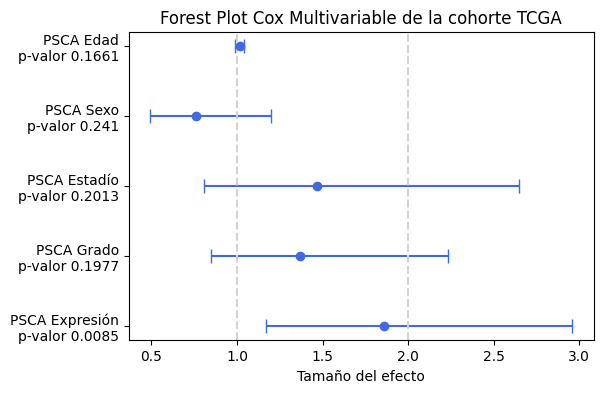

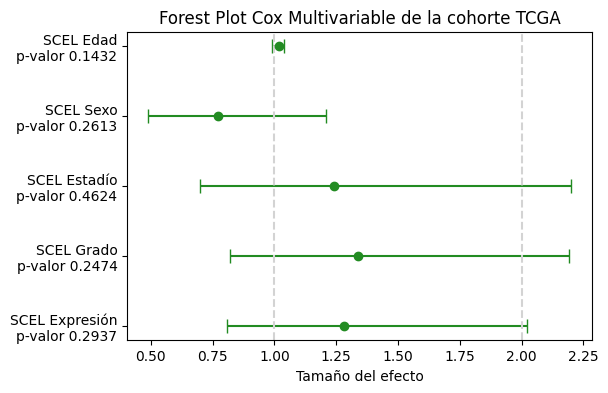

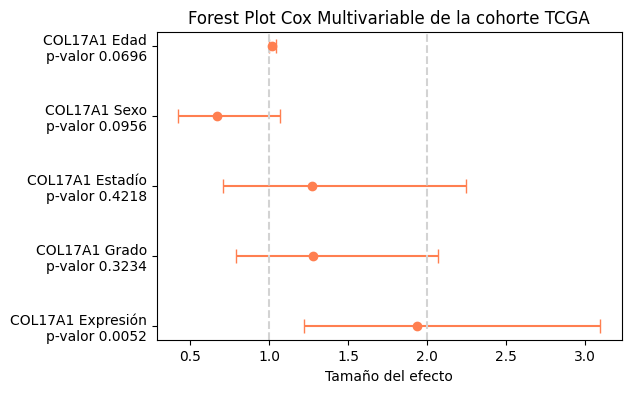

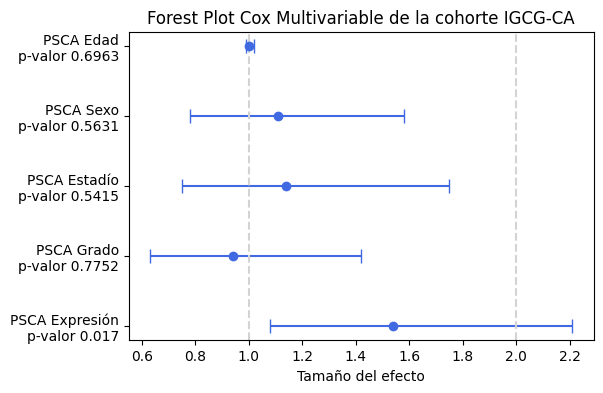

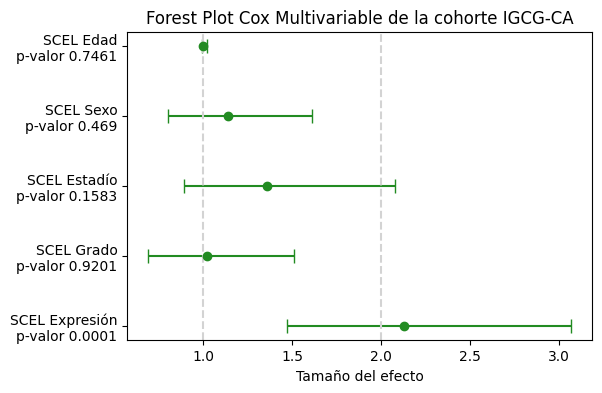

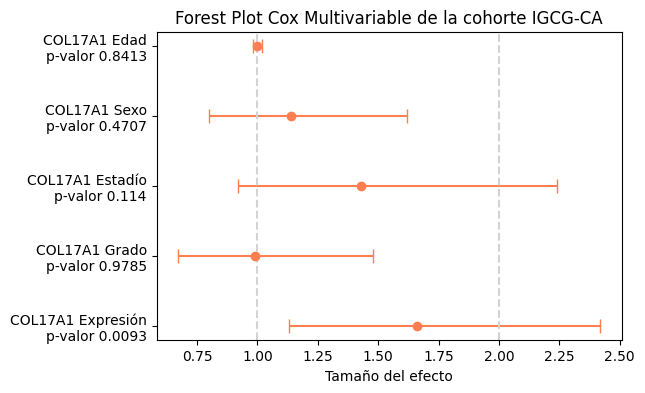

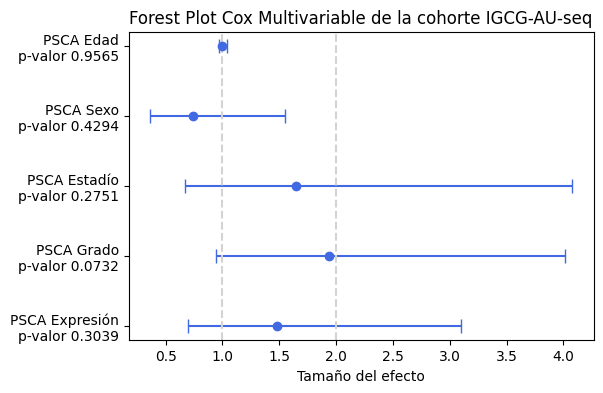

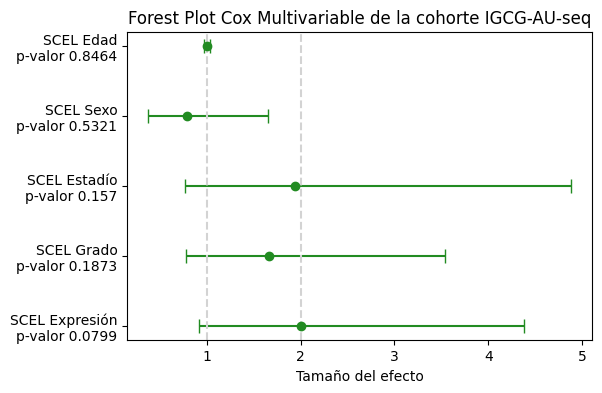

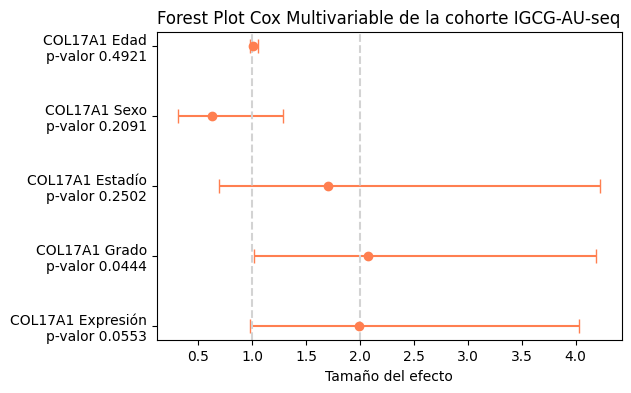

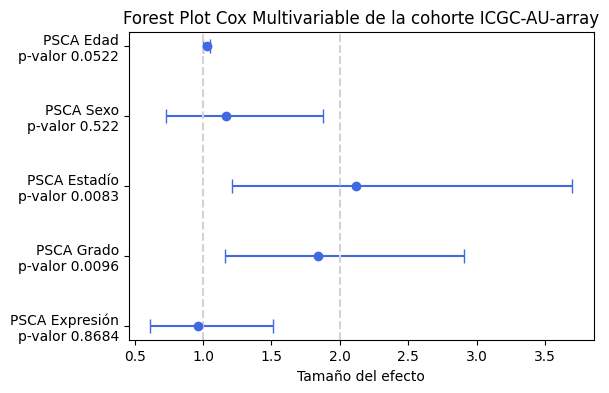

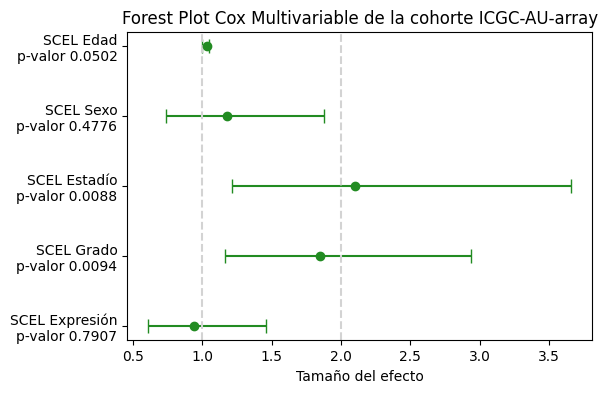

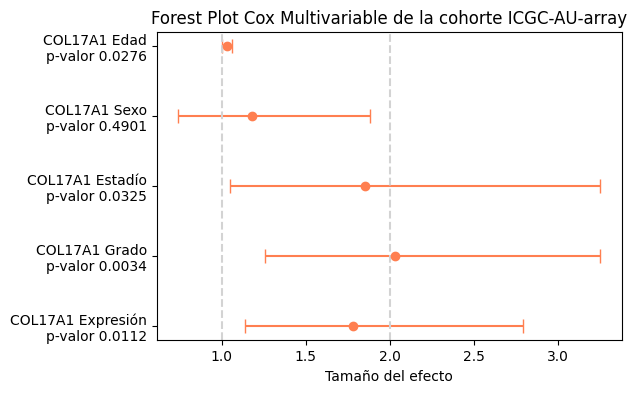

In [51]:
# Representación del COX multivariable cohorte TCGA
ForestPlot (TCGACox, "TCGA")

# Representación del COX multivariable cohorte CA
ForestPlot (CACox, "IGCG-CA")

# Representación del COX multivariable cohorte AUseq
ForestPlot (AUseqCox, "IGCG-AU-seq")

# Representación del COX multivariable cohorte AUarray
ForestPlot (AUarrayCox, "ICGC-AU-array")

#### 2.3. Análisis de la expresión de los marcadores en función del subtipo molecular

In [52]:
# Hacer una lista con los marcadores identificados como significativos
Marcadores_significativos = ["PSCA", "SCEL", "COL17A1"]

In [53]:
# Realización de una función para comparar la expresión por subtipo molecular
def ComparacionGrupos (Cohorte, Proteinas, key):
    Cohorte["Subtipo"] = Cohorte['Subtipo molecular'].replace({0: "Clásico", 1: "Basal"})
    colores = {'PSCA': 'turquoise', 'SCEL': 'springgreen', 'COL17A1': 'coral'}
    for Proteina in Proteinas:
        plt.figure(figsize=(4, 4))
        ## Análisis de expresión de la proteína por Moffit subtype
        sns.boxplot(x='Subtipo', y= Proteina, data=Cohorte, showfliers=False, color = colores[Proteina], order = ["Basal", "Clásico"])
        sns.swarmplot(x='Subtipo', y= Proteina, data=Cohorte, color='black', alpha=0.5,  size=2.5)  # Agrega puntos
        # Calcular los límites basados en los datos
        plt.ylim(min(Cohorte[Proteina]) - 0.25*min(Cohorte[Proteina]), max(Cohorte[Proteina]) + 0.25*max(Cohorte[Proteina]))
        plt.xlabel('Subtipo')
        plt.ylabel('Expresión ' + Proteina)
        plt.title('Subtipo molecular en la cohorte '+ key)
        plt.show()
        descriptive_stats = Cohorte.groupby('Subtipo')[Proteina].describe()
        desvest = Cohorte.groupby('Subtipo')[Proteina].sem()
        print(descriptive_stats)
        print("Desviación estándar de la media: ", desvest)

        grupo_Basal = Cohorte[Cohorte['Subtipo'] == 'Basal'][Proteina]
        grupo_Classical = Cohorte[Cohorte['Subtipo'] == 'Clásico'][Proteina]
        t_statistic, p_value = ttest_ind(grupo_Basal, grupo_Classical)
        print("Prueba t de Student Basal con Clasic:")
        print("Estadístico de prueba:", t_statistic)
        print("Valor p:", p_value)

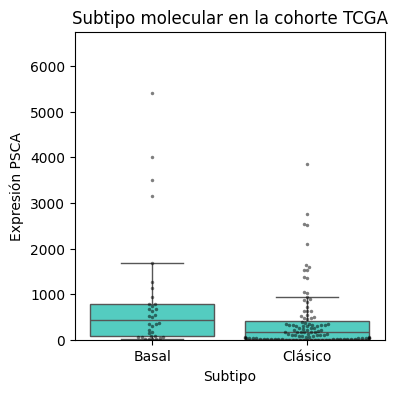

         count        mean          std       min        25%         50%  \
Subtipo                                                                    
Basal     34.0  860.327983  1271.063232  15.00688  89.315750  431.880521   
Clásico  107.0  406.006399   660.872727   0.00000  23.623465  166.430417   

                75%          max  
Subtipo                           
Basal    787.101516  5403.484432  
Clásico  421.295617  3843.259779  
Desviación estándar de la media:  Subtipo
Basal      217.985546
Clásico     63.888978
Name: PSCA, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 2.726086764183793
Valor p: 0.007234460129327828


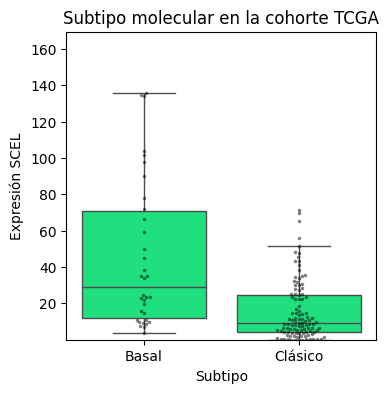

         count       mean        std       min        25%        50%  \
Subtipo                                                                
Basal     34.0  45.703260  40.890943  3.816884  11.885265  29.075413   
Clásico  107.0  15.778023  16.504839  0.010145   4.117328   9.382969   

               75%         max  
Subtipo                         
Basal    70.544312  135.547365  
Clásico  24.823370   71.465757  
Desviación estándar de la media:  Subtipo
Basal      7.012739
Clásico    1.595583
Name: SCEL, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 6.181421168753676
Valor p: 6.634994714490557e-09


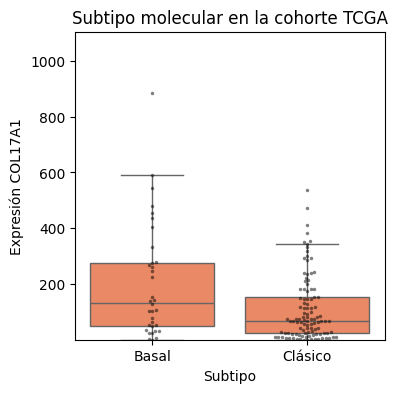

         count        mean         std       min        25%         50%  \
Subtipo                                                                   
Basal     34.0  206.018017  207.669792  0.750778  50.545486  132.362553   
Clásico  107.0  109.648635  116.108154  0.220830  22.730433   68.566241   

                75%         max  
Subtipo                          
Basal    276.840714  883.649894  
Clásico  152.406813  537.925553  
Desviación estándar de la media:  Subtipo
Basal      35.615076
Clásico    11.224599
Name: COL17A1, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 3.417274288597298
Valor p: 0.000829925336809504


c:\Users\Sara\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


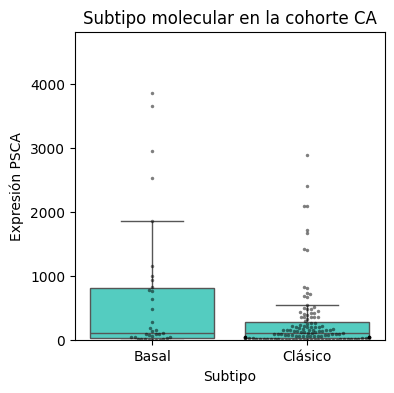

         count        mean          std       min        25%         50%  \
Subtipo                                                                    
Basal     35.0  652.025146  1051.545539  0.490796  34.234368  104.455773   
Clásico  128.0  272.948652   489.748955  0.000000  22.802851   97.968069   

                75%          max  
Subtipo                           
Basal    804.009588  3847.597667  
Clásico  271.734822  2887.540179  
Desviación estándar de la media:  Subtipo
Basal      177.743637
Clásico     43.288101
Name: PSCA, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 3.056672642781405
Valor p: 0.0026209714290897843


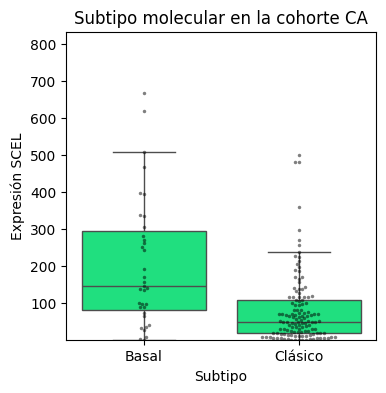

         count        mean         std       min        25%         50%  \
Subtipo                                                                   
Basal     35.0  204.416797  174.559729  0.200194  80.962682  145.465542   
Clásico  128.0   79.843760   94.527801  0.183316  17.847993   49.203244   

                75%         max  
Subtipo                          
Basal    292.467637  665.566368  
Clásico  108.351285  499.472685  
Desviación estándar de la media:  Subtipo
Basal      29.505980
Clásico     8.355156
Name: SCEL, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 5.624314960220064
Valor p: 8.057092713309132e-08


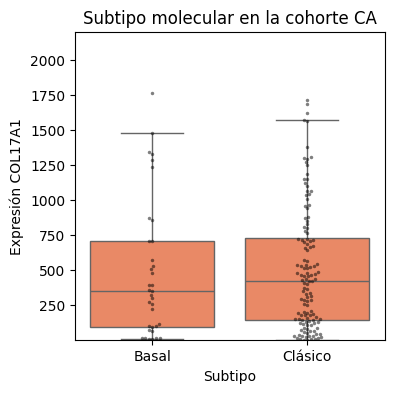

         count        mean         std       min         25%         50%  \
Subtipo                                                                    
Basal     35.0  488.093895  492.444445  3.257893   94.064428  346.710990   
Clásico  128.0  502.361974  436.541189  0.821714  140.066974  423.197548   

                75%          max  
Subtipo                           
Basal    703.461447  1761.640146  
Clásico  729.304336  1717.573741  
Desviación estándar de la media:  Subtipo
Basal      83.238304
Clásico    38.585154
Name: COL17A1, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: -0.16662299191303173
Valor p: 0.8678757790023938


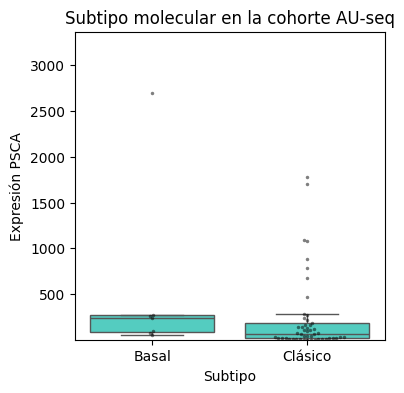

         count        mean         std        min        25%         50%  \
Subtipo                                                                    
Basal      7.0  527.050730  960.053323  49.096481  85.571672  236.968388   
Clásico   49.0  234.313129  414.835190   1.206689  16.453104   67.774788   

                75%          max  
Subtipo                           
Basal    269.189912  2693.767074  
Clásico  188.963539  1775.891912  
Desviación estándar de la media:  Subtipo
Basal      362.866048
Clásico     59.262170
Name: PSCA, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 1.4336370763028317
Valor p: 0.15744102793888787


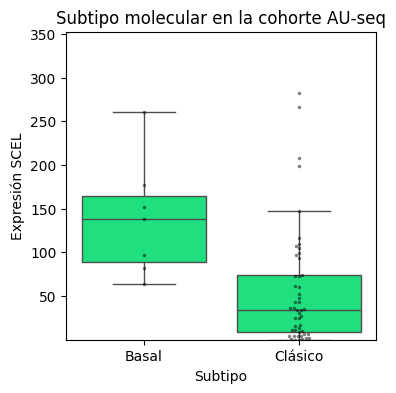

         count        mean        std        min        25%         50%  \
Subtipo                                                                   
Basal      7.0  138.521113  67.081909  63.595876  89.308883  138.713050   
Clásico   49.0   56.479745  67.354831   0.077286   8.945647   33.994959   

                75%         max  
Subtipo                          
Basal    164.273355  260.174391  
Clásico   73.705039  281.941179  
Desviación estándar de la media:  Subtipo
Basal      25.354578
Clásico     9.622119
Name: SCEL, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 3.015868598744758
Valor p: 0.003900766151026493


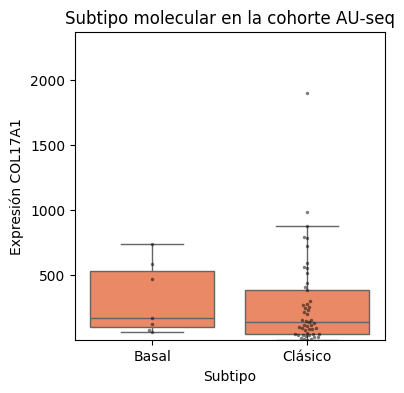

         count        mean         std        min        25%         50%  \
Subtipo                                                                    
Basal      7.0  315.971865  276.388614  57.977102  96.301851  169.332143   
Clásico   49.0  274.865105  348.641010   1.247938  46.899858  134.466464   

                75%          max  
Subtipo                           
Basal    528.249194   735.391724  
Clásico  386.829541  1895.616181  
Desviación estándar de la media:  Subtipo
Basal      104.465077
Clásico     49.805859
Name: COL17A1, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 0.2980178184261246
Valor p: 0.7668332252175125


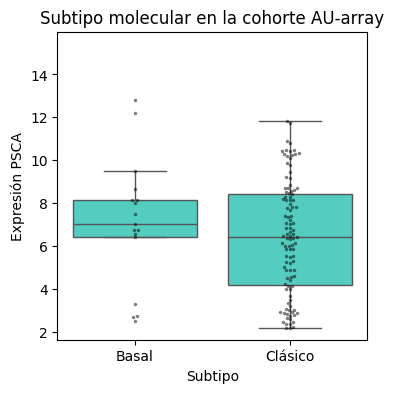

         count      mean       std       min       25%       50%       75%  \
Subtipo                                                                      
Basal     17.0  7.039342  3.008799  2.522921  6.398023  7.042788  8.149563   
Clásico  108.0  6.423801  2.629755  2.178067  4.198602  6.427157  8.420110   

               max  
Subtipo             
Basal    12.791030  
Clásico  11.822674  
Desviación estándar de la media:  Subtipo
Basal      0.729741
Clásico    0.253048
Name: PSCA, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 0.8795569745422103
Valor p: 0.3808145190496549


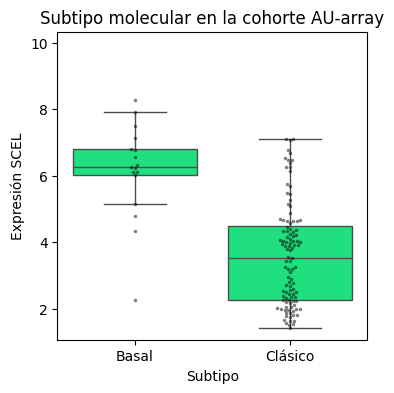

         count      mean       std       min       25%       50%       75%  \
Subtipo                                                                      
Basal     17.0  6.151961  1.431190  2.261675  6.023713  6.249271  6.806079   
Clásico  108.0  3.606798  1.540682  1.415986  2.245728  3.528074  4.495504   

              max  
Subtipo            
Basal    8.267850  
Clásico  7.108784  
Desviación estándar de la media:  Subtipo
Basal      0.347114
Clásico    0.148252
Name: SCEL, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 6.388386574449086
Valor p: 3.1257893709696522e-09


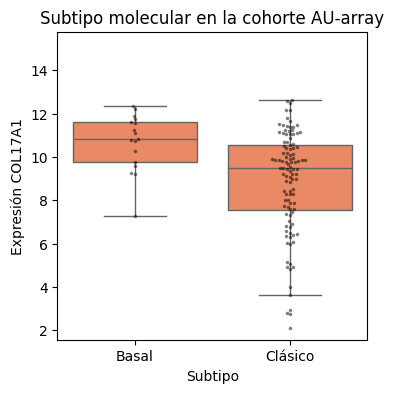

         count       mean       std       min       25%        50%        75%  \
Subtipo                                                                         
Basal     17.0  10.676138  1.323047  7.268904  9.756805  10.822991  11.610774   
Clásico  108.0   8.883441  2.365852  2.083375  7.555682   9.474634  10.569200   

               max  
Subtipo             
Basal    12.352782  
Clásico  12.627785  
Desviación estándar de la media:  Subtipo
Basal      0.320886
Clásico    0.227654
Name: COL17A1, dtype: float64
Prueba t de Student Basal con Clasic:
Estadístico de prueba: 3.0432452538743946
Valor p: 0.0028622855098796207


In [54]:
ComparacionGrupos (TCGA, Marcadores_significativos, "TCGA")
ComparacionGrupos (CA, Marcadores_significativos, "CA")
ComparacionGrupos (AUseq, Marcadores_significativos, "AU-seq")
ComparacionGrupos (AUarray, Marcadores_significativos, "AU-array")